In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')  

# statsmodels.regression.rolling: Importing the RollingOLS class for rolling linear regression.
# pandas_datareader.data: Importing the web module from pandas_datareader for fetching financial data.
# matplotlib.pyplot: Importing the pyplot module for plotting.
# statsmodels.api: Importing the statsmodels library for statistical models and tests.
# pandas: Importing the pandas library for data manipulation and analysis.
# numpy: Importing the numpy library for numerical operations.
# datetime: Importing the datetime module for working with dates.
# yfinance: Importing the yfinance library for fetching financial data from Yahoo Finance.
# pandas_ta: Importing the pandas_ta library for technical analysis.
# warnings: Importing the warnings module to suppress warnings.

# downloading the data
nifty50 = pd.read_html('https://en.wikipedia.org/wiki/NIFTY_50#Constituents')[2]
symbols_list = nifty50['Symbol'].unique().tolist()

# Add '.NS' to each ticker symbol in the list
symbols_list = [ticker + '.NS' for ticker in symbols_list]

# Display the modified list
print(symbols_list)


end_date = '2024-04-25'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

# Setting start and end dates:
# Defining the end_date as '2023-12-03'.
# Calculating the start_date as 8 years (365 days * 8) before the end_date.capitalize

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

['ADANIENT.NS', 'ADANIPORTS.NS', 'APOLLOHOSP.NS', 'ASIANPAINT.NS', 'AXISBANK.NS', 'BAJAJ-AUTO.NS', 'BAJFINANCE.NS', 'BAJAJFINSV.NS', 'BPCL.NS', 'BHARTIARTL.NS', 'BRITANNIA.NS', 'CIPLA.NS', 'COALINDIA.NS', 'DIVISLAB.NS', 'DRREDDY.NS', 'EICHERMOT.NS', 'GRASIM.NS', 'HCLTECH.NS', 'HDFCBANK.NS', 'HDFCLIFE.NS', 'HEROMOTOCO.NS', 'HINDALCO.NS', 'HINDUNILVR.NS', 'ICICIBANK.NS', 'INDUSINDBK.NS', 'INFY.NS', 'ITC.NS', 'JSWSTEEL.NS', 'KOTAKBANK.NS', 'LT.NS', 'LTIM.NS', 'M&M.NS', 'MARUTI.NS', 'NESTLEIND.NS', 'NTPC.NS', 'ONGC.NS', 'POWERGRID.NS', 'RELIANCE.NS', 'SBILIFE.NS', 'SHRIRAMFIN.NS', 'SBIN.NS', 'SUNPHARMA.NS', 'TATAMOTORS.NS', 'TATASTEEL.NS', 'TCS.NS', 'TATACONSUM.NS', 'TECHM.NS', 'TITAN.NS', 'ULTRACEMCO.NS', 'WIPRO.NS']
[*********************100%%**********************]  50 of 50 completed


adj close        close         high          low  \
date       ticker                                                              
2016-04-27 ADANIENT.NS      45.782692    46.725281    47.297424    45.608231   
           ADANIPORTS.NS   231.692932   241.250000   242.000000   227.649994   
           APOLLOHOSP.NS  1284.430176  1316.800049  1339.000000  1310.050049   
           ASIANPAINT.NS   842.873596   889.849976   891.000000   871.000000   
           AXISBANK.NS     454.976257   465.500000   473.500000   458.049988   
...                               ...          ...          ...          ...   
2024-04-24 TCS.NS         3803.406250  3831.050049  3898.000000  3824.449951   
           TECHM.NS       1185.699951  1185.699951  1207.949951  1181.500000   
           TITAN.NS       3609.750000  3609.750000  3644.850098  3580.050049   
           ULTRACEMCO.NS  9658.849609  9658.849609  9686.799805  9542.799805   
           WIPRO.NS        459.899994   459.899994   464.649994   458.600006   

                                 open      volume  
date       ticker                                  
2016-04-27 ADANIENT.NS      45.880684   6246060.0  
           ADANIPORTS.NS   230.000000   7177265.0  
           APOLLOHOSP.NS  1329.900024    231338.0  
           ASIANPAINT.NS   875.700012    553126.0  
           AXISBANK.NS     461.299988  29544825.0  
...                               ...         ...  
2024-04-24 TCS.NS         3890.000000   1317312.0  
           TECHM.NS       1207.949951   1375843.0  
           TITAN.NS       3642.000000    652811.0  
           ULTRACEMCO.NS  9578.000000    317929.0  
           WIPRO.NS        463.899994   2957584.0  

[97944 rows x 6 columns]

### Calculate features and technical indicators

* Garman -klass volatilit
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

In [2]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

# df: This is the DataFrame on which the grouping operation is applied.

# .groupby(level=1): This is a method provided by pandas for grouping data based on one or more levels of a multi-level index. In this case, it's specifying to group the DataFrame by the second level of its index.

# The index of df has two levels ('date' and 'ticker'). By specifying level=1, the grouping is done based on the 'ticker' level. This means that the DataFrame will be split into groups, each corresponding to a unique 'ticker' in the second level of the index.

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

# 1e6 is a shorthand notation in Python for expressing the number 1 followed by 6 zeros, which is equivalent to 1,000,000. It is often used to represent one million in a more concise form.

df

adj close        close         high          low  \
date       ticker                                                              
2016-04-27 ADANIENT.NS      45.782692    46.725281    47.297424    45.608231   
           ADANIPORTS.NS   231.692932   241.250000   242.000000   227.649994   
           APOLLOHOSP.NS  1284.430176  1316.800049  1339.000000  1310.050049   
           ASIANPAINT.NS   842.873596   889.849976   891.000000   871.000000   
           AXISBANK.NS     454.976257   465.500000   473.500000   458.049988   
...                               ...          ...          ...          ...   
2024-04-24 TCS.NS         3803.406250  3831.050049  3898.000000  3824.449951   
           TECHM.NS       1185.699951  1185.699951  1207.949951  1181.500000   
           TITAN.NS       3609.750000  3609.750000  3644.850098  3580.050049   
           ULTRACEMCO.NS  9658.849609  9658.849609  9686.799805  9542.799805   
           WIPRO.NS        459.899994   459.899994   464.649994   458.600006   

                                 open      volume  garman_klass_vol  \
date       ticker                                                     
2016-04-27 ADANIENT.NS      45.880684   6246060.0          0.000660   
           ADANIPORTS.NS   230.000000   7177265.0          0.001848   
           APOLLOHOSP.NS  1329.900024    231338.0         -0.000229   
           ASIANPAINT.NS   875.700012    553126.0         -0.000306   
           AXISBANK.NS     461.299988  29544825.0          0.000477   
...                               ...         ...               ...   
2024-04-24 TCS.NS         3890.000000   1317312.0         -0.000014   
           TECHM.NS       1207.949951   1375843.0          0.000112   
           TITAN.NS       3642.000000    652811.0          0.000130   
           ULTRACEMCO.NS  9578.000000    317929.0          0.000085   
           WIPRO.NS        463.899994   2957584.0          0.000057   

                                rsi    bb_low    bb_mid   bb_high       atr  \
date       ticker                                                             
2016-04-27 ADANIENT.NS          NaN       NaN       NaN       NaN       NaN   
           ADANIPORTS.NS        NaN       NaN       NaN       NaN       NaN   
           APOLLOHOSP.NS        NaN       NaN       NaN       NaN       NaN   
           ASIANPAINT.NS        NaN       NaN       NaN       NaN       NaN   
           AXISBANK.NS          NaN       NaN       NaN       NaN       NaN   
...                             ...       ...       ...       ...       ...   
2024-04-24 TCS.NS         42.016696  8.235730  8.264381  8.293031  1.409188   
           TECHM.NS       37.891556  7.070573  7.119534  7.168494  0.359230   
           TITAN.NS       46.797476  8.169608  8.211308  8.253007  2.036742   
           ULTRACEMCO.NS  48.645358  9.138886  9.180060  9.221235  1.291577   
           WIPRO.NS       40.502965  6.101993  6.158039  6.214085  0.896825   

                              macd  dollar_volume  
date       ticker                                  
2016-04-27 ADANIENT.NS         NaN     285.961441  
           ADANIPORTS.NS       NaN    1662.921573  
           APOLLOHOSP.NS       NaN     297.137508  
           ASIANPAINT.NS       NaN     466.215301  
           AXISBANK.NS         NaN   13442.193902  
...                            ...            ...  
2024-04-24 TCS.NS        -1.479978    5010.272694  
           TECHM.NS      -1.352911    1631.336978  
           TITAN.NS      -1.168752    2356.484507  
           ULTRACEMCO.NS -0.969017    3070.828397  
           WIPRO.NS      -1.619500    1360.192864  

[97944 rows x 14 columns]

# Taking First 30 Companies beacuse also listed in Sensex

## Getting monthly index and average dollar volume and making it multiindex

In [3]:
last_cols =[c for c in df.columns.unique(0)if c not in['dollar_volume','volume','open','high','low','close']]
# exclude given column and include all the remaining one and store it in last_cols
last_cols
data=pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
# Resamples the 'dollar_volume' column by month, calculates the mean for each month, and then stacks the DataFrame.
#The result is a DataFrame with a MultiIndex containing levels 'date' and 'ticker', with the 'dollar_volume' as a single column.
# The capital M stands for month dollar volume mean is taken             
df.unstack()[last_cols].resample('M').last().stack('ticker')],axis=1).dropna()
# Unstacks the entire DataFrame and selects only the columns specified in last_cols.
# Resamples the resulting DataFrame by month and selects the last value for each month.
data

dollar_volume    adj close  garman_klass_vol  \
date       ticker                                                        
2016-06-30 ADANIENT.NS       254.926276    46.316601          0.001279   
           ADANIPORTS.NS     863.473086   198.655670         -0.000277   
           APOLLOHOSP.NS     254.969480  1283.162231         -0.000157   
           ASIANPAINT.NS     955.804171   955.406006         -0.000900   
           AXISBANK.NS      3966.301786   521.438965          0.000364   
...                                 ...          ...               ...   
2024-04-30 TCS.NS          10204.427873  3803.406250         -0.000014   
           TECHM.NS         2239.098766  1185.699951          0.000112   
           TITAN.NS         3554.021414  3609.750000          0.000130   
           ULTRACEMCO.NS    3392.974173  9658.849609          0.000085   
           WIPRO.NS         3310.745923   459.899994          0.000057   

                                rsi    bb_low    bb_mid   bb_high       atr  \
date       ticker                                                             
2016-06-30 ADANIENT.NS    63.011532  3.647976  3.743308  3.838641 -0.764360   
           ADANIPORTS.NS  51.470445  5.265697  5.287668  5.309639 -1.200995   
           APOLLOHOSP.NS  47.150199  7.126829  7.165620  7.204411 -1.038250   
           ASIANPAINT.NS  59.860439  6.826608  6.855566  6.884524 -1.309199   
           AXISBANK.NS    59.988087  6.209572  6.246599  6.283626 -0.934850   
...                             ...       ...       ...       ...       ...   
2024-04-30 TCS.NS         42.016696  8.235730  8.264381  8.293031  1.409188   
           TECHM.NS       37.891556  7.070573  7.119534  7.168494  0.359230   
           TITAN.NS       46.797476  8.169608  8.211308  8.253007  2.036742   
           ULTRACEMCO.NS  48.645358  9.138886  9.180060  9.221235  1.291577   
           WIPRO.NS       40.502965  6.101993  6.158039  6.214085  0.896825   

                              macd  
date       ticker                   
2016-06-30 ADANIENT.NS   -0.150692  
           ADANIPORTS.NS -0.210622  
           APOLLOHOSP.NS -0.380492  
           ASIANPAINT.NS  0.064681  
           AXISBANK.NS    0.155350  
...                            ...  
2024-04-30 TCS.NS        -1.479978  
           TECHM.NS      -1.352911  
           TITAN.NS      -1.168752  
           ULTRACEMCO.NS -0.969017  
           WIPRO.NS      -1.619500  

[4713 rows x 9 columns]

In [4]:
data['dollar_volume'].unstack('ticker').rolling(5*12).mean()
#This applies a rolling window operation with a window size of 5*12 (60) periods.

ticker      ADANIENT.NS  ADANIPORTS.NS  APOLLOHOSP.NS  ASIANPAINT.NS  \
date                                                                   
2016-06-30          NaN            NaN            NaN            NaN   
2016-07-31          NaN            NaN            NaN            NaN   
2016-08-31          NaN            NaN            NaN            NaN   
2016-09-30          NaN            NaN            NaN            NaN   
2016-10-31          NaN            NaN            NaN            NaN   
...                 ...            ...            ...            ...   
2023-12-31  5623.716077    4627.327948    2376.815457    3480.072207   
2024-01-31  5795.943237    4759.277969    2398.398577    3506.240353   
2024-02-29  5880.684155    4804.832743    2430.085509    3556.614352   
2024-03-31  5954.023226    4862.108590    2479.726556    3587.691901   
2024-04-30  6002.309334    4947.004618    2508.509942    3605.149456   

ticker      AXISBANK.NS  BAJAJ-AUTO.NS  BAJAJFINSV.NS  BAJFINANCE.NS  \
date                                                                   
2016-06-30          NaN            NaN            NaN            NaN   
2016-07-31          NaN            NaN            NaN            NaN   
2016-08-31          NaN            NaN            NaN            NaN   
2016-09-30          NaN            NaN            NaN            NaN   
2016-10-31          NaN            NaN            NaN            NaN   
...                 ...            ...            ...            ...   
2023-12-31  9268.108791    1787.217446    3908.273650   10398.784318   
2024-01-31  9326.845929    1851.654915    3926.407532   10508.868228   
2024-02-29  9375.474050    1887.097069    3936.949529   10591.566379   
2024-03-31  9428.916333    1954.037570    3952.496449   10692.239370   
2024-04-30  9535.972340    2010.737837    3961.903189   10757.936902   

ticker      BHARTIARTL.NS      BPCL.NS  ...  SHRIRAMFIN.NS  SUNPHARMA.NS  \
date                                    ...                                
2016-06-30            NaN          NaN  ...            NaN           NaN   
2016-07-31            NaN          NaN  ...            NaN           NaN   
2016-08-31            NaN          NaN  ...            NaN           NaN   
2016-09-30            NaN          NaN  ...            NaN           NaN   
2016-10-31            NaN          NaN  ...            NaN           NaN   
...                   ...          ...  ...            ...           ...   
2023-12-31    6548.892994  2215.049414  ...    2106.556199   3333.142394   
2024-01-31    6623.111912  2273.117451  ...    2140.164047   3283.208410   
2024-02-29    6702.487526  2409.858027  ...    2175.591729   3297.854865   
2024-03-31    6797.890010  2473.648089  ...    2244.299038   3327.085368   
2024-04-30    6902.986476  2520.902945  ...    2268.151843   3376.055212   

ticker      TATACONSUM.NS  TATAMOTORS.NS  TATASTEEL.NS       TCS.NS  \
date                                                                  
2016-06-30            NaN            NaN           NaN          NaN   
2016-07-31            NaN            NaN           NaN          NaN   
2016-08-31            NaN            NaN           NaN          NaN   
2016-09-30            NaN            NaN           NaN          NaN   
2016-10-31            NaN            NaN           NaN          NaN   
...                   ...            ...           ...          ...   
2023-12-31    1460.502794    9308.651271   7326.598705  7353.188185   
2024-01-31    1489.205117    9420.836257   7365.080207  7411.134716   
2024-02-29    1513.106968    9525.523374   7387.868595  7457.004339   
2024-03-31    1548.128302    9719.803410   7533.022061  7586.386824   
2024-04-30    1581.619256    9713.309899   7612.693186  7646.143010   

ticker         TECHM.NS     TITAN.NS  ULTRACEMCO.NS     WIPRO.NS  
date                                                              
2016-06-30          NaN          NaN            NaN          NaN  
2016-07-31  

In [5]:
data['dollar_vol_rank']= (data.groupby('date')['dollar_volume'].rank(ascending=False))
#selecting rows where the 'dollar_vol_rank' is less than 30.
data = data[data['dollar_vol_rank']<50].drop(['dollar_volume','dollar_vol_rank'],axis=1)

In [6]:
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                              
2016-06-30 ADANIENT.NS      46.316601          0.001279  63.011532  3.647976   
           ADANIPORTS.NS   198.655670         -0.000277  51.470445  5.265697   
           APOLLOHOSP.NS  1283.162231         -0.000157  47.150199  7.126829   
           ASIANPAINT.NS   955.406006         -0.000900  59.860439  6.826608   
           AXISBANK.NS     521.438965          0.000364  59.988087  6.209572   
...                               ...               ...        ...       ...   
2024-04-30 TCS.NS         3803.406250         -0.000014  42.016696  8.235730   
           TECHM.NS       1185.699951          0.000112  37.891556  7.070573   
           TITAN.NS       3609.750000          0.000130  46.797476  8.169608   
           ULTRACEMCO.NS  9658.849609          0.000085  48.645358  9.138886   
           WIPRO.NS        459.899994          0.000057  40.502965  6.101993   

                            bb_mid   bb_high       atr      macd  
date       ticker                                                 
2016-06-30 ADANIENT.NS    3.743308  3.838641 -0.764360 -0.150692  
           ADANIPORTS.NS  5.287668  5.309639 -1.200995 -0.210622  
           APOLLOHOSP.NS  7.165620  7.204411 -1.038250 -0.380492  
           ASIANPAINT.NS  6.855566  6.884524 -1.309199  0.064681  
           AXISBANK.NS    6.246599  6.283626 -0.934850  0.155350  
...                            ...       ...       ...       ...  
2024-04-30 TCS.NS         8.264381  8.293031  1.409188 -1.479978  
           TECHM.NS       7.119534  7.168494  0.359230 -1.352911  
           TITAN.NS       8.211308  8.253007  2.036742 -1.168752  
           ULTRACEMCO.NS  9.180060  9.221235  1.291577 -0.969017  
           WIPRO.NS       6.158039  6.214085  0.896825 -1.619500  

[4636 rows x 8 columns]

# Calculate Monthly returns for different time horizion features
* TO capture time series dynamics that reflects ,for example,momentum patterns, we compute historical returns using the method .pct_change(lag) that is, returns over various monthly periods as identified by lags

In [7]:
def calculate_returns(df):
    
   
    outlier_cutoff =0.005
    # what is a outlier
    # refer this video 'https://youtu.be/rZJbj2I-_Ek?feature=shared'
    # an outlier helps us to konw irrelevance in data like 9,10,10,11,12,36 so outlier is used and 36 is removed
    lags=[1,2,3,6,9,12]
    for lag in lags:
        df[f'return_{lag}m']=(df['adj close'] #: Creates a new column in the DataFrame for each lag, representing returns over that lag period.
                            .pct_change(lag)  #Calculates the percentage change over the specified lag period.
                            .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),upper=x.quantile(1-outlier_cutoff)))
                            .add(1)
                            .pow(1/lag)
                            .sub(1))
    return df

data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna() #Applies the calculate_returns function to each group of the DataFrame, grouping by the second level of the index ('ticker').
# .dropna(): Drops any rows with missing values in the resulting DataFrame.
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                              
2017-06-30 ADANIENT.NS      70.796326          0.000190  57.671203  4.182520   
           ADANIPORTS.NS   348.667816         -0.000611  55.352508  5.830071   
           APOLLOHOSP.NS  1243.218872          0.000105  51.017366  7.100977   
           ASIANPAINT.NS  1054.742065         -0.000339  42.566595  6.967230   
           AXISBANK.NS     510.382416          0.000268  54.685895  6.194448   
...                               ...               ...        ...       ...   
2024-04-30 TCS.NS         3803.406250         -0.000014  42.016696  8.235730   
           TECHM.NS       1185.699951          0.000112  37.891556  7.070573   
           TITAN.NS       3609.750000          0.000130  46.797476  8.169608   
           ULTRACEMCO.NS  9658.849609          0.000085  48.645358  9.138886   
           WIPRO.NS        459.899994          0.000057  40.502965  6.101993   

                            bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                             
2017-06-30 ADANIENT.NS    4.252703  4.322886 -0.746783 -0.140024   0.135274   
           ADANIPORTS.NS  5.858318  5.886564 -0.892924  0.045400   0.070944   
           APOLLOHOSP.NS  7.141823  7.182669 -0.952959 -0.211768   0.052391   
           ASIANPAINT.NS  6.998525  7.029819 -1.046429 -0.287907  -0.040243   
           AXISBANK.NS    6.221152  6.247856 -1.216675 -0.171695   0.006420   
...                            ...       ...       ...       ...        ...   
2024-04-30 TCS.NS         8.264381  8.293031  1.409188 -1.479978  -0.011673   
           TECHM.NS       7.119534  7.168494  0.359230 -1.352911  -0.049996   
           TITAN.NS       8.211308  8.253007  2.036742 -1.168752  -0.050516   
           ULTRACEMCO.NS  9.180060  9.221235  1.291577 -0.969017  -0.009262   
           WIPRO.NS       6.158039  6.214085  0.896825 -1.619500  -0.042075   

                          return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                      
2017-06-30 ADANIENT.NS     0.103210   0.068984   0.095889   0.081151   
           ADANIPORTS.NS   0.052555   0.022507   0.051600   0.039244   
           APOLLOHOSP.NS   0.016607   0.030366   0.012944  -0.003331   
           ASIANPAINT.NS  -0.006976   0.009648   0.036498  -0.005188   
           AXISBANK.NS     0.007526   0.017716   0.023537  -0.005026   
...                             ...        ...        ...        ...   
2024-04-30 TCS.NS         -0.032777   0.001317   0.022452   0.013454   
           TECHM.NS       -0.035220  -0.038437   0.009386   0.008004   
           TITAN.NS       -0.002023  -0.007979   0.020835   0.020618   
           ULTRACEMCO.NS  -0.011875  -0.016957   0.023096   0.016742   
           WIPRO.NS       -0.058294  -0.012888   0.031871   0.014451   

                          return_12m  
date       ticker                     
2017-06-30 ADANIENT.NS      0.035991  
           ADANIPORTS.NS    0.047995  
           APOLLOHOSP.NS   -0.002632  
           ASIANPAINT.NS    0.008277  
           AXISBANK.NS     -0.001784  
...                              ...  
2024-04-30 TCS.NS           0.016061  
           TECHM.NS         0.015410  
           TITAN.NS         0.026631  
           ULTRACEMCO.NS    0.021057  
           WIPRO.NS         0.015104  

[4036 rows x 14 columns]

## Download Fama-French Factors and Calculate Rolling Factor Betas.
* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

### what is fama FRench model?

* but Gene Fama and Kenneth French noticed that small-cap stocks (companies with smaller market capitalizations) tended to outperform large-cap stocks and that companies with a higher book-to-market ratio (value stocks) tended to outperform companies with a lower book-to-market ratio (growth stocks).

* MKt-rf= it tells about market risk
* SMB long on portfolio with small cap stocks and short on portfolio on the large cap stocks
* HML long on portfolio with high book to market ratio and short on portfolio with low book to market ratio (low book to market ratio= companies that will grow eg paytm,ideaforage) high book to market are the value stocks
* Robust minus weak (RMW), which compares the returns of firms with high, or robust, operating profitability
* and those with weak, or low, operating profitability; and conservative minus aggressive (CMA)
* we are comparing the number to usa stock market because no data has been available for indian stock market but the numbers are taken on yearly basis so error is less and numbers remain constant

In [8]:
 factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF',axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data= factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                          
2017-06-30 ADANIENT.NS    0.0078  0.0258  0.0148 -0.0222  0.0000   0.135274
           ADANIPORTS.NS  0.0078  0.0258  0.0148 -0.0222  0.0000   0.070944
           APOLLOHOSP.NS  0.0078  0.0258  0.0148 -0.0222  0.0000   0.052391
           ASIANPAINT.NS  0.0078  0.0258  0.0148 -0.0222  0.0000  -0.040243
           AXISBANK.NS    0.0078  0.0258  0.0148 -0.0222  0.0000   0.006420
...                          ...     ...     ...     ...     ...        ...
2024-03-31 TCS.NS         0.0283 -0.0116  0.0419  0.0148  0.0118  -0.053430
           TECHM.NS       0.0283 -0.0116  0.0419  0.0148  0.0118  -0.020214
           TITAN.NS       0.0283 -0.0116  0.0419  0.0148  0.0118   0.048946
           ULTRACEMCO.NS  0.0283 -0.0116  0.0419  0.0148  0.0118  -0.014481
           WIPRO.NS       0.0283 -0.0116  0.0419  0.0148  0.0118  -0.074238

[3987 rows x 6 columns]

In [9]:
observation = factor_data.groupby(level=1).size()
valid_stocks = observation[observation>=10]
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]
factor_data
# Checks if each 'ticker' is in the index of valid stocks obtained in the previous step.
# factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]: Filters the DataFrame to include only rows corresponding to valid stocks.

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                          
2017-06-30 ADANIENT.NS    0.0078  0.0258  0.0148 -0.0222  0.0000   0.135274
           ADANIPORTS.NS  0.0078  0.0258  0.0148 -0.0222  0.0000   0.070944
           APOLLOHOSP.NS  0.0078  0.0258  0.0148 -0.0222  0.0000   0.052391
           ASIANPAINT.NS  0.0078  0.0258  0.0148 -0.0222  0.0000  -0.040243
           AXISBANK.NS    0.0078  0.0258  0.0148 -0.0222  0.0000   0.006420
...                          ...     ...     ...     ...     ...        ...
2024-03-31 TCS.NS         0.0283 -0.0116  0.0419  0.0148  0.0118  -0.053430
           TECHM.NS       0.0283 -0.0116  0.0419  0.0148  0.0118  -0.020214
           TITAN.NS       0.0283 -0.0116  0.0419  0.0148  0.0118   0.048946
           ULTRACEMCO.NS  0.0283 -0.0116  0.0419  0.0148  0.0118  -0.014481
           WIPRO.NS       0.0283 -0.0116  0.0419  0.0148  0.0118  -0.074238

[3987 rows x 6 columns]

In [10]:
betas =(factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))
betas
#the code calculates rolling betas for each stock by applying the RollingOLS model to the 'return_1m' as the dependent variable and the other factors from the factor_data DataFrame as independent variables. The rolling window size is 
# determined by the minimum of 24 and the number of observations available for each stock. The resulting betas DataFrame contains the time-varying beta coefficients for each stock with respect to the specified factors.
# rolling returns gives the average of any stocks that give return for eg market is up 3% than it wont affect rolling return

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                         
2017-06-30 ADANIENT.NS         NaN       NaN       NaN       NaN       NaN
           ADANIPORTS.NS       NaN       NaN       NaN       NaN       NaN
           APOLLOHOSP.NS       NaN       NaN       NaN       NaN       NaN
           ASIANPAINT.NS       NaN       NaN       NaN       NaN       NaN
           AXISBANK.NS         NaN       NaN       NaN       NaN       NaN
...                            ...       ...       ...       ...       ...
2024-03-31 TCS.NS         0.481685  0.530365 -0.281647  0.089587  0.282007
           TECHM.NS       0.687501 -0.597493  0.555180 -0.538303 -0.854302
           TITAN.NS       0.564590 -0.642423  0.306895 -0.641926 -0.452928
           ULTRACEMCO.NS  0.615740  0.721669 -0.302552  0.283523  0.164083
           WIPRO.NS       0.678047 -0.099152 -0.093704 -0.937965  0.204611

[3987 rows x 5 columns]

In [11]:
factors=['Mkt-RF','SMB','HML','RMW','CMA']

data =data.join(betas.groupby('ticker').shift())
data.loc[:,factors] = data.groupby('ticker',group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))
data = data.dropna()
data = data.drop('adj close', axis=1)
data
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4036 entries, (Timestamp('2017-06-30 00:00:00'), 'ADANIENT.NS') to (Timestamp('2024-04-30 00:00:00'), 'WIPRO.NS')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  4036 non-null   float64
 1   rsi               4036 non-null   float64
 2   bb_low            4036 non-null   float64
 3   bb_mid            4036 non-null   float64
 4   bb_high           4036 non-null   float64
 5   atr               4036 non-null   float64
 6   macd              4036 non-null   float64
 7   return_1m         4036 non-null   float64
 8   return_2m         4036 non-null   float64
 9   return_3m         4036 non-null   float64
 10  return_6m         4036 non-null   float64
 11  return_9m         4036 non-null   float64
 12  return_12m        4036 non-null   float64
 13  Mkt-RF            4036 non-null   float64
 14  SMB               4036 non-null   float64
 15 

# At this point we have to decide on what ML model and approach to use for predictions etc.
6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
* K-Means Clustering

* You may want to initialize predefined centroids for each cluster based on your research.

* Then we will pre-define our centroids for each cluster.

In [12]:
from sklearn.cluster import KMeans

#data = data.drop('cluster',axis=1) # added later after clustering with random

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init='random').fit(df).labels_ # changed 'random' to initial centriods
    return df
data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)
data



garman_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                           
2017-06-30 ADANIENT.NS            0.000190  57.671203  4.182520  4.252703   
           ADANIPORTS.NS         -0.000611  55.352508  5.830071  5.858318   
           APOLLOHOSP.NS          0.000105  51.017366  7.100977  7.141823   
           ASIANPAINT.NS         -0.000339  42.566595  6.967230  6.998525   
           AXISBANK.NS            0.000268  54.685895  6.194448  6.221152   
...                                    ...        ...       ...       ...   
2024-04-30 TCS.NS                -0.000014  42.016696  8.235730  8.264381   
           TECHM.NS               0.000112  37.891556  7.070573  7.119534   
           TITAN.NS               0.000130  46.797476  8.169608  8.211308   
           ULTRACEMCO.NS          0.000085  48.645358  9.138886  9.180060   
           WIPRO.NS               0.000057  40.502965  6.101993  6.158039   

                           bb_high       atr      macd  return_1m  return_2m  \
date       ticker                                                              
2017-06-30 ADANIENT.NS    4.322886 -0.746783 -0.140024   0.135274   0.103210   
           ADANIPORTS.NS  5.886564 -0.892924  0.045400   0.070944   0.052555   
           APOLLOHOSP.NS  7.182669 -0.952959 -0.211768   0.052391   0.016607   
           ASIANPAINT.NS  7.029819 -1.046429 -0.287907  -0.040243  -0.006976   
           AXISBANK.NS    6.247856 -1.216675 -0.171695   0.006420   0.007526   
...                            ...       ...       ...        ...        ...   
2024-04-30 TCS.NS         8.293031  1.409188 -1.479978  -0.011673  -0.032777   
           TECHM.NS       7.168494  0.359230 -1.352911  -0.049996  -0.035220   
           TITAN.NS       8.253007  2.036742 -1.168752  -0.050516  -0.002023   
           ULTRACEMCO.NS  9.221235  1.291577 -0.969017  -0.009262  -0.011875   
           WIPRO.NS       6.214085  0.896825 -1.619500  -0.042075  -0.058294   

                          return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                       
2017-06-30 ADANIENT.NS     0.068984   0.095889   0.081151    0.035991   
           ADANIPORTS.NS   0.022507   0.051600   0.039244    0.047995   
           APOLLOHOSP.NS   0.030366   0.012944  -0.003331   -0.002632   
           ASIANPAINT.NS   0.009648   0.036498  -0.005188    0.008277   
           AXISBANK.NS     0.017716   0.023537  -0.005026   -0.001784   
...                             ...        ...        ...         ...   
2024-04-30 TCS.NS          0.001317   0.022452   0.013454    0.016061   
           TECHM.NS       -0.038437   0.009386   0.008004    0.015410   
           TITAN.NS       -0.007979   0.020835   0.020618    0.026631   
           ULTRACEMCO.NS  -0.016957   0.023096   0.016742    0.021057   
           WIPRO.NS       -0.012888   0.031871   0.014451    0.015104   

                            Mkt-RF       SMB       HML       RMW       CMA  \
date       ticker                                                            
2017-06-30 ADANIENT.NS    0.337507 -0.370782  0.175597  1.767549 -0.430027   
           ADANIPORTS.NS  0.241177  0.212301  0.442829  0.477193 -0.557421   
           APOLLOHOSP.NS  0.395156 -0.401291  0.222053 -0.234960 -1.400143   
           ASIANPAINT.NS  0.117394  0.215835  0.185982  0.454187 -0.271948   
           AXISBANK.NS    0.821948  0.221947  0.444211 -0.370440  0.026871   
...                            ...       ...       ...       ...       ...   
2024-04-30 TCS.NS         0.413854  0.098949 -0.101795 -0.112002  0.137264   
           TECHM.NS       0.705386 -0.476668  0.292511 -0.416311 -0.648934   
           TITAN.NS       0.376473  0.176135  0.305927  0.616734 -0.001162   
           ULTRACEMCO.NS  0.362569 -0.072014  0.660721  0.250283 -1.374793   
           WIPRO.NS       0.496787 -0.267074  0.263701 -0.117042 -0.609687   

                  

In [13]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]
# the impoertant thing we are chosing which column iloc[:,5] is atr and 1 is rsi
    plt.scatter(cluster_0.iloc[:,5] , cluster_0.iloc[:,1] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,5] , cluster_1.iloc[:,1] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,5] , cluster_2.iloc[:,1] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,5] , cluster_3.iloc[:,1] , color = 'black', label='cluster 3')
# labeling
    x_label = data.columns[5]
    y_label = data.columns[1]
    plt.title(f'Clusters based on {x_label} and {y_label}')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()
    return

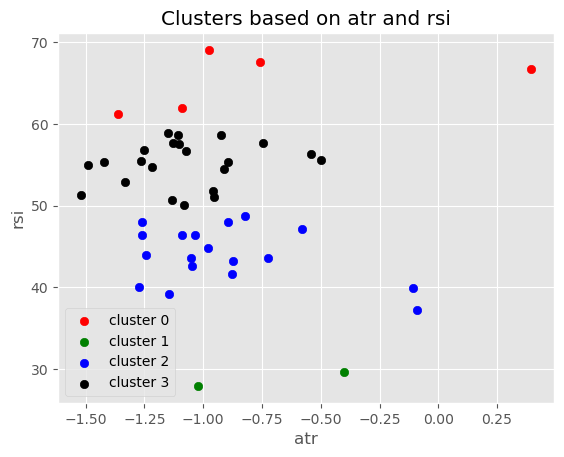

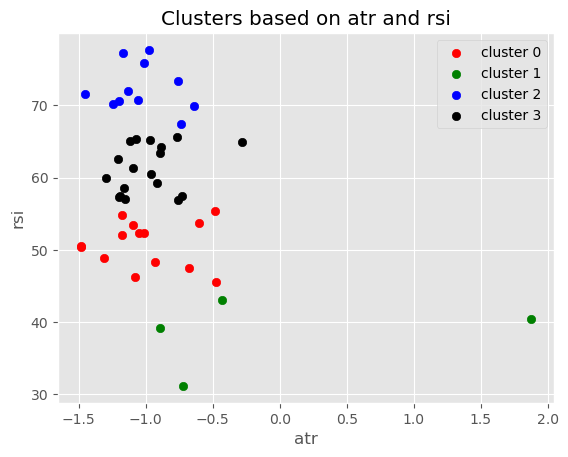

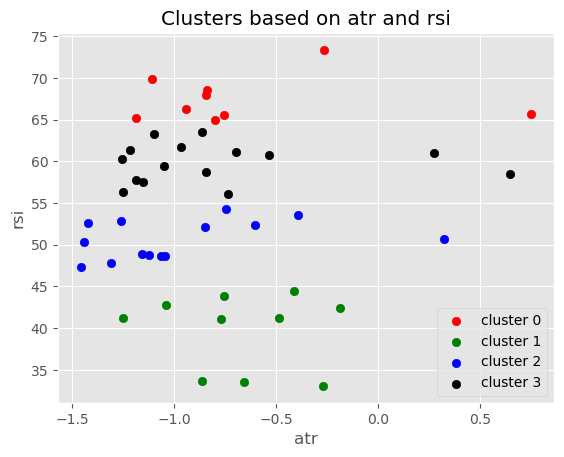

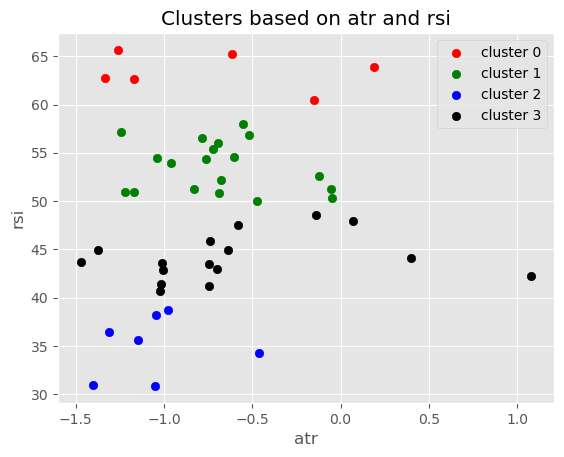

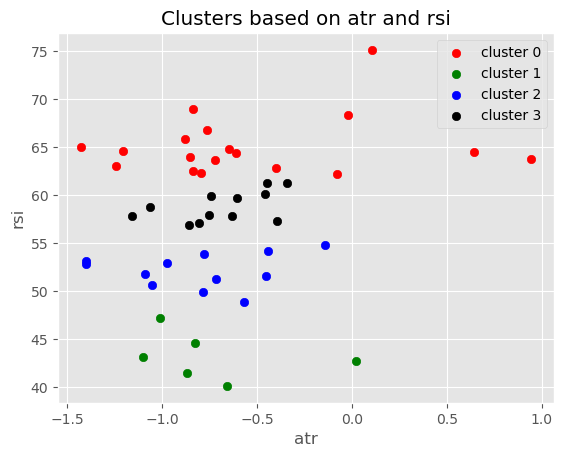

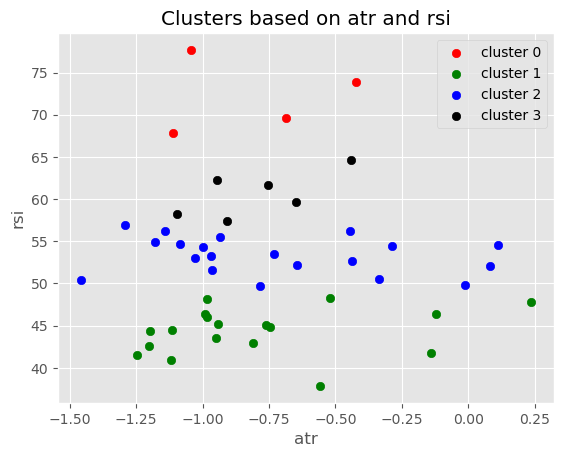

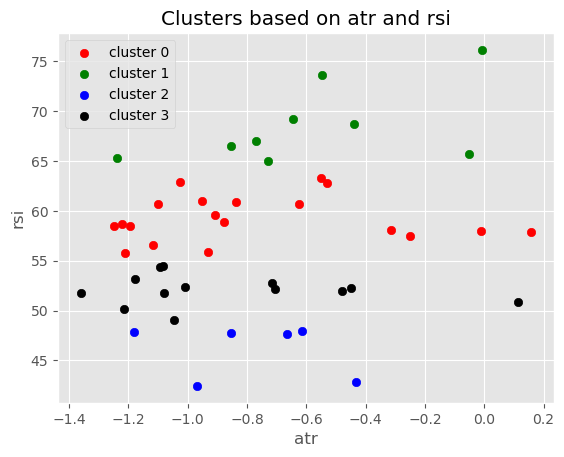

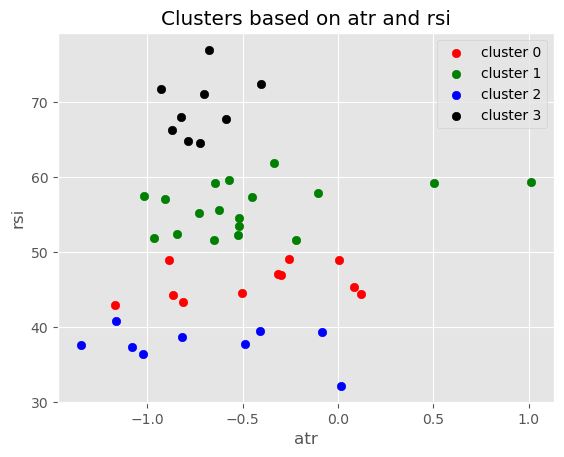

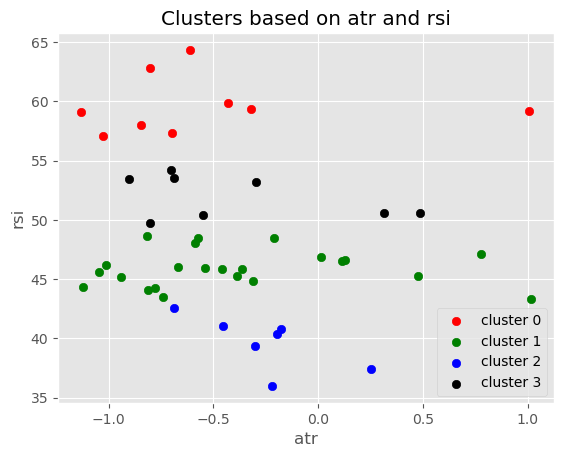

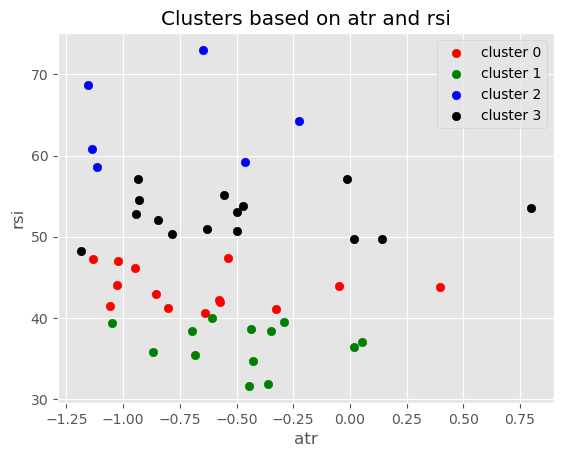

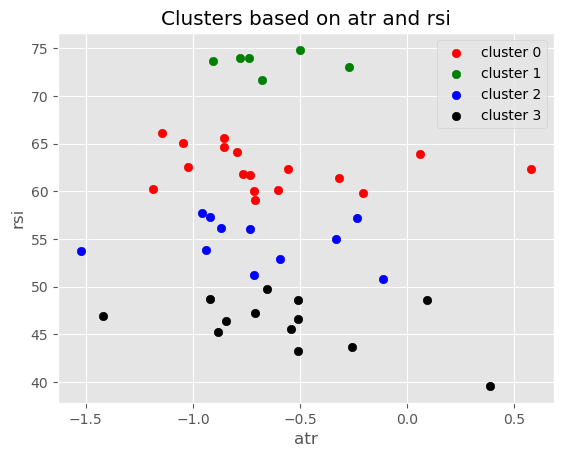

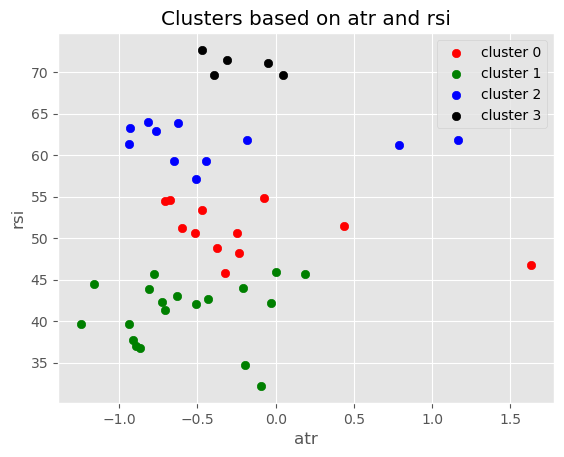

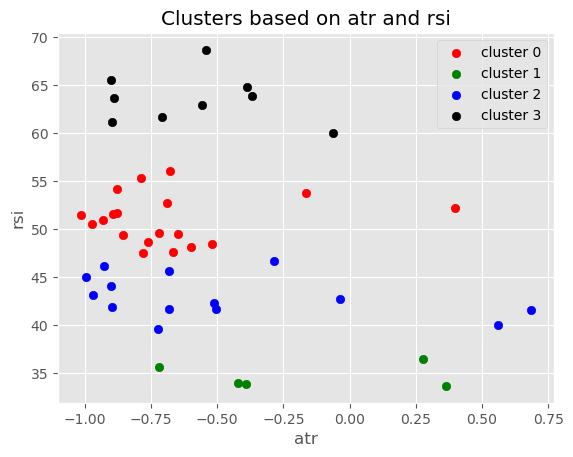

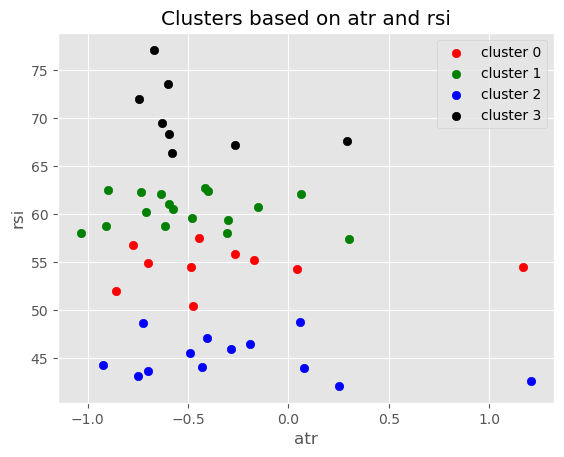

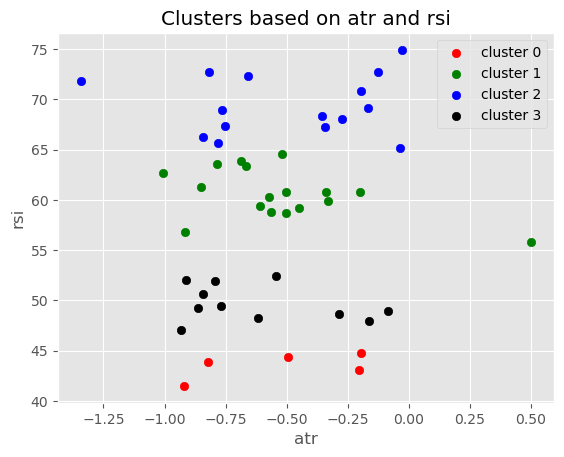

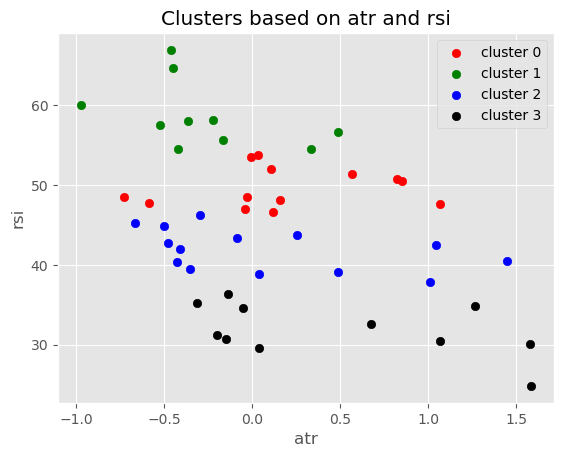

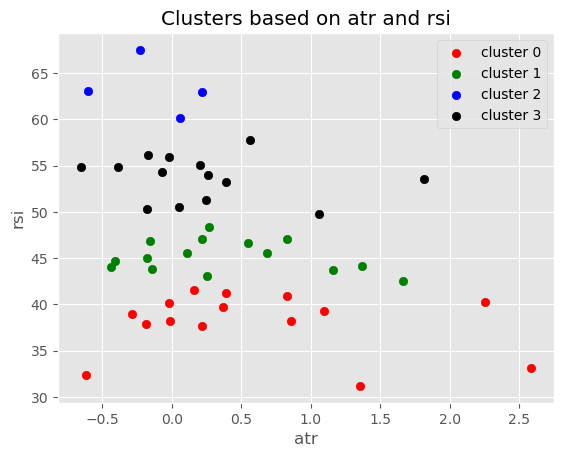

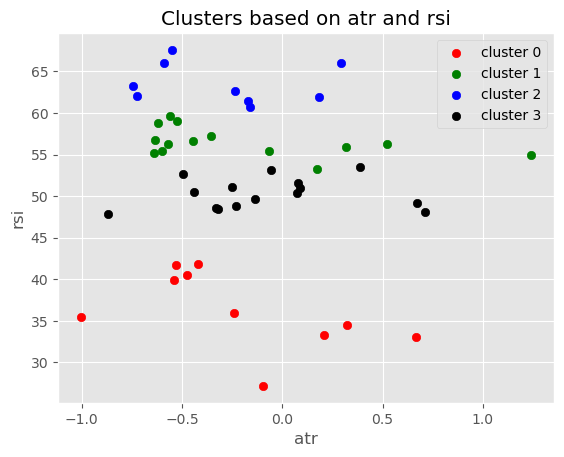

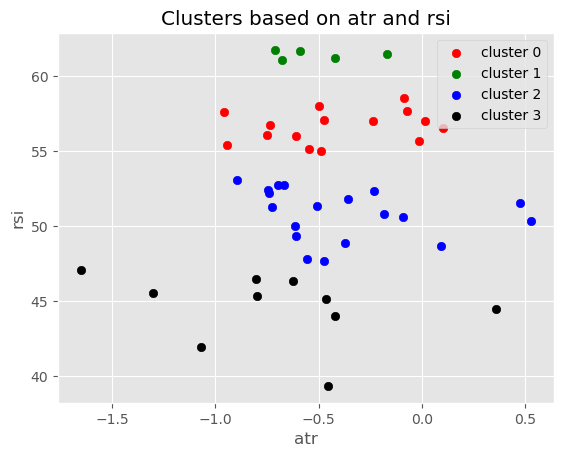

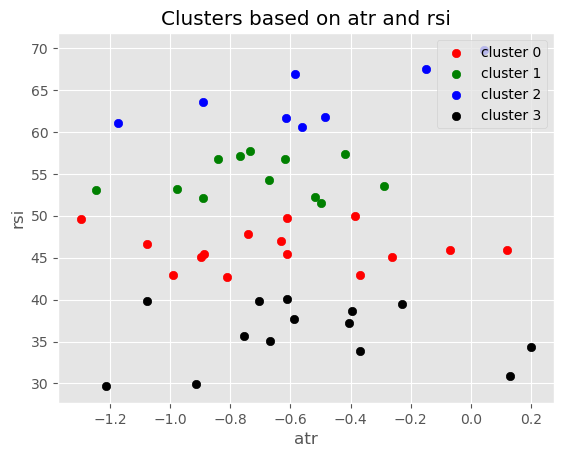

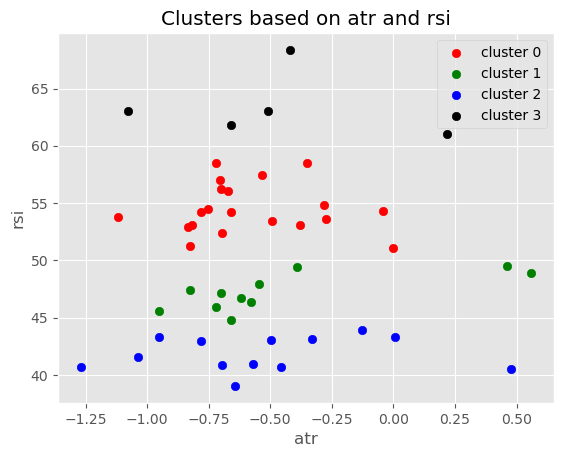

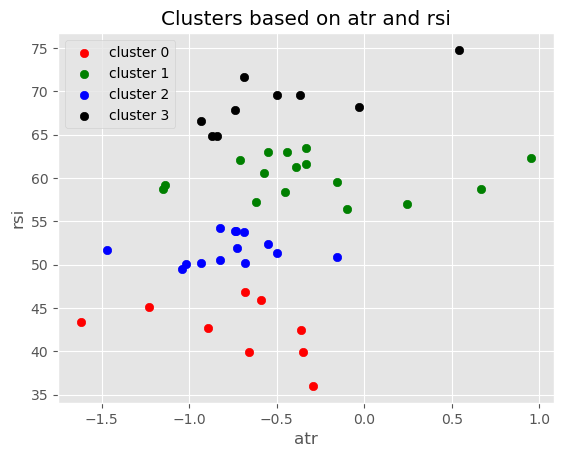

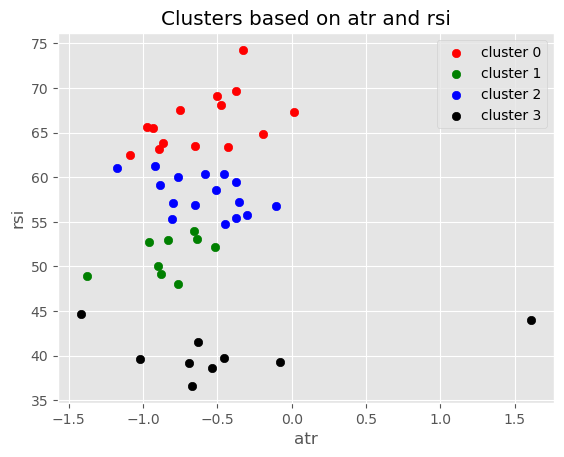

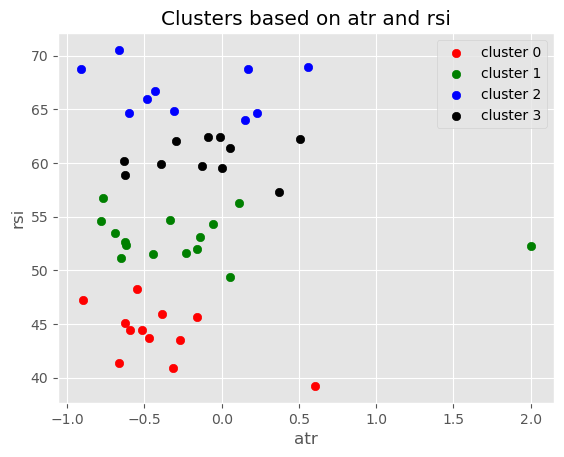

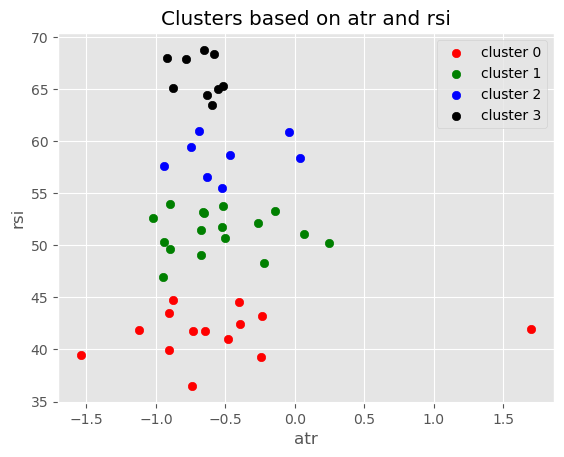

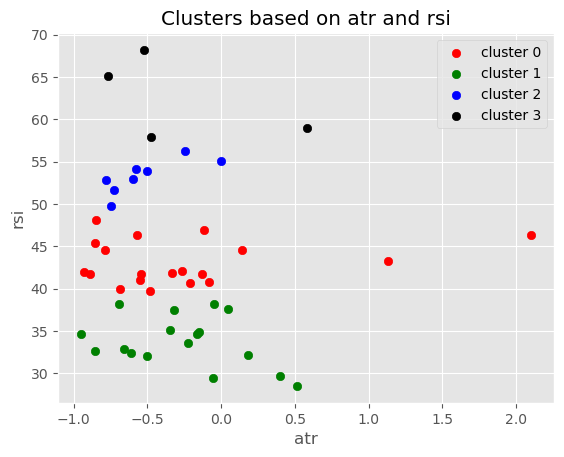

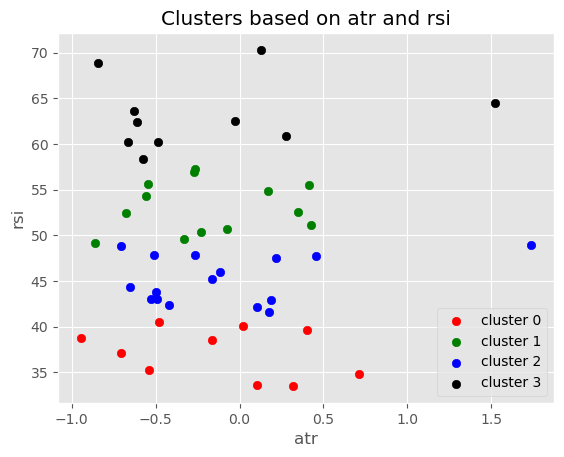

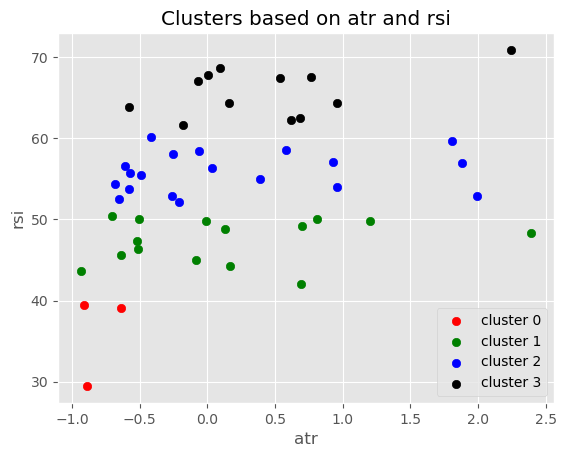

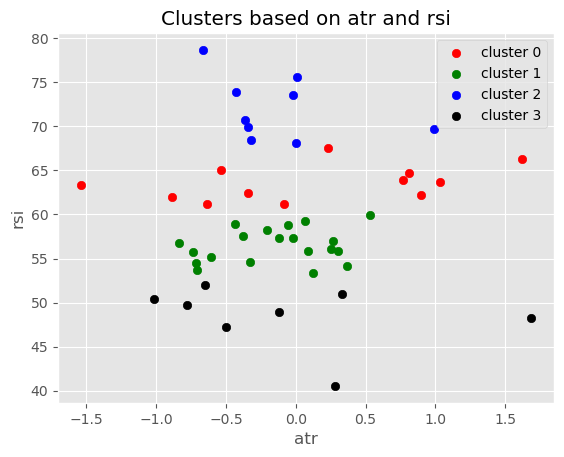

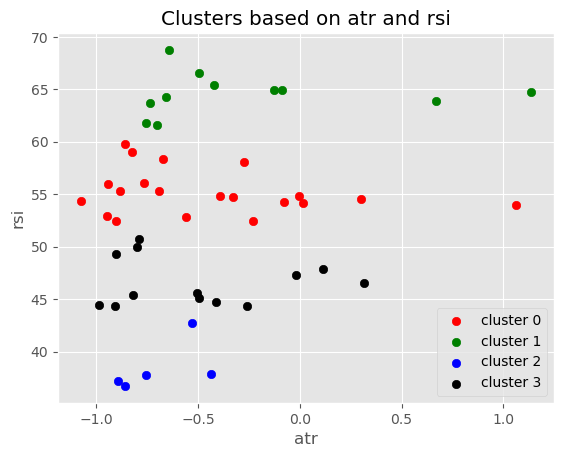

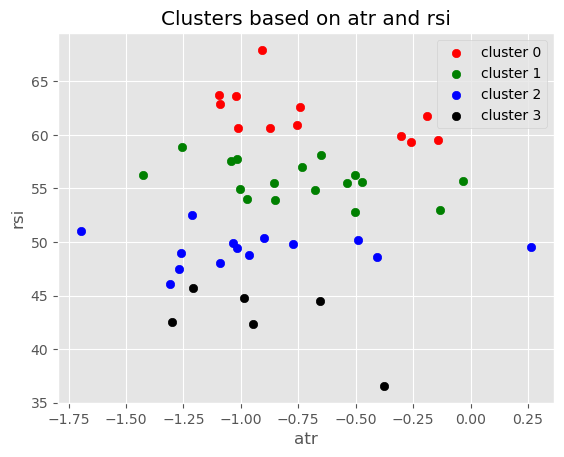

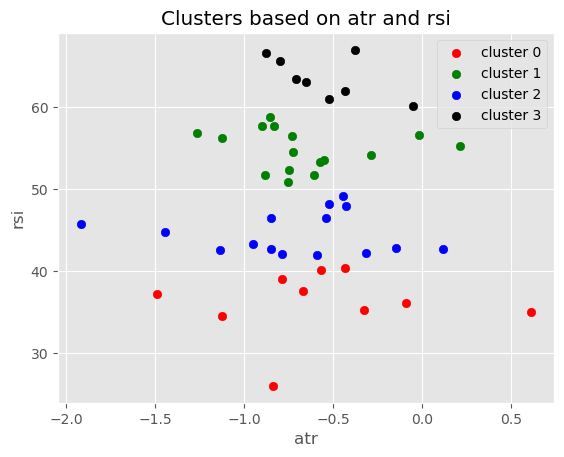

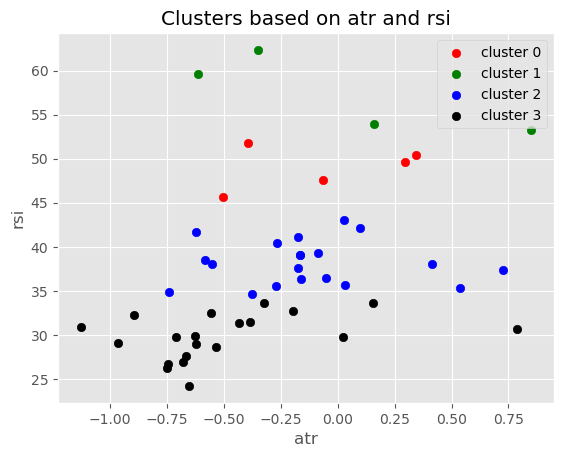

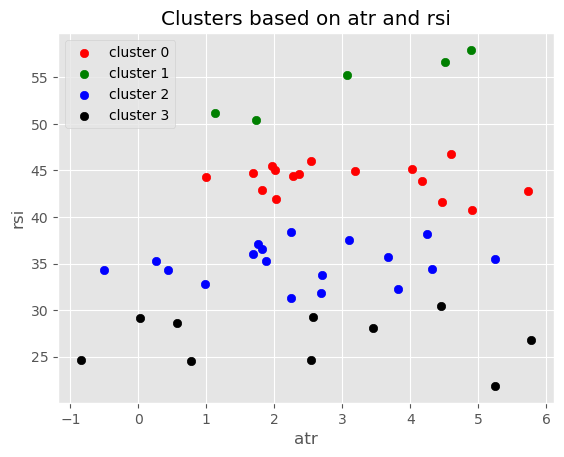

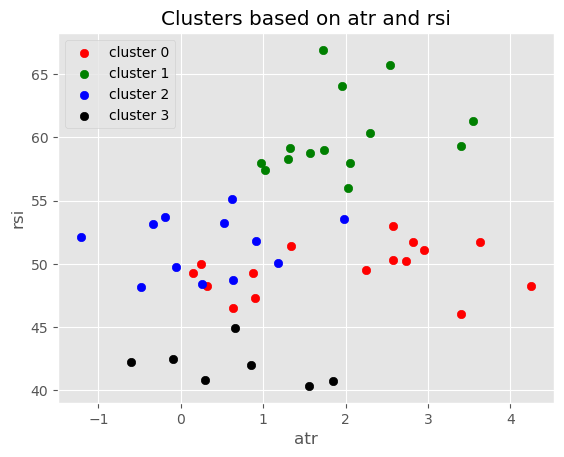

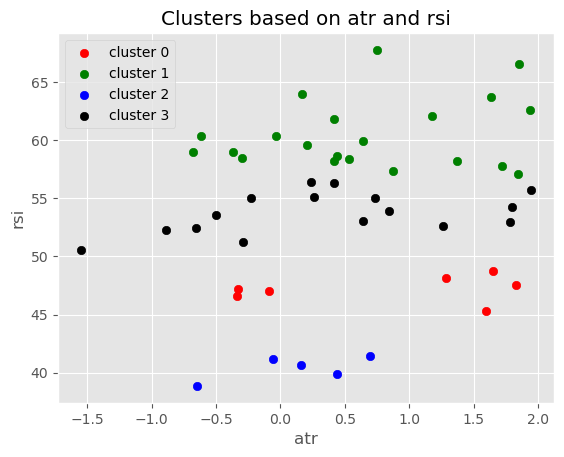

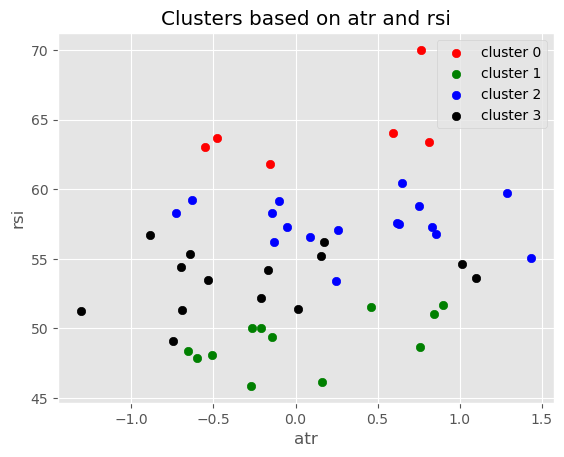

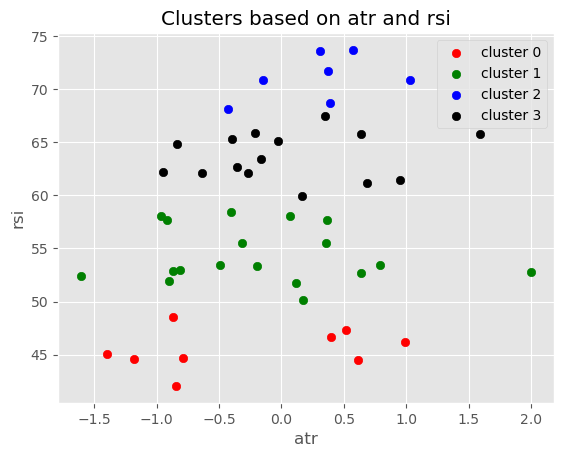

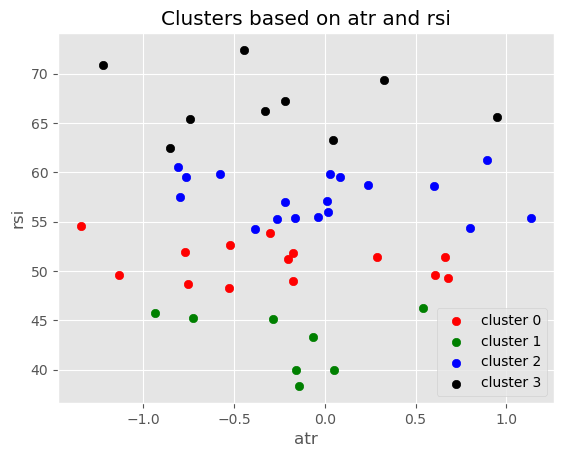

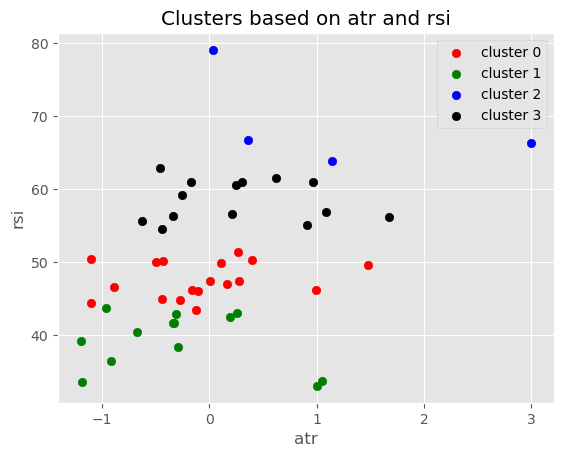

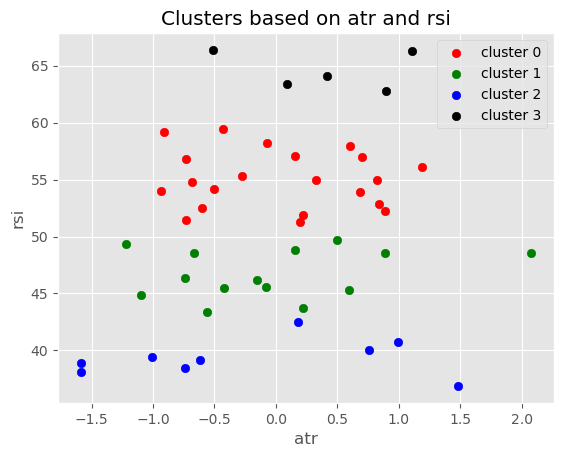

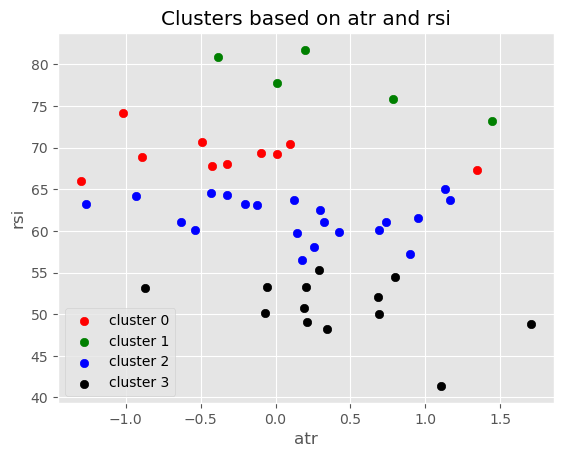

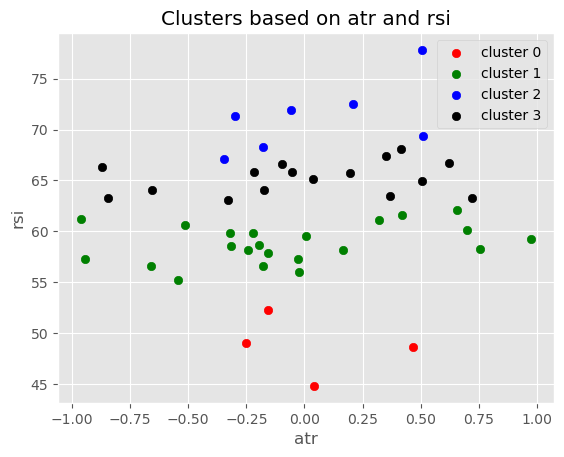

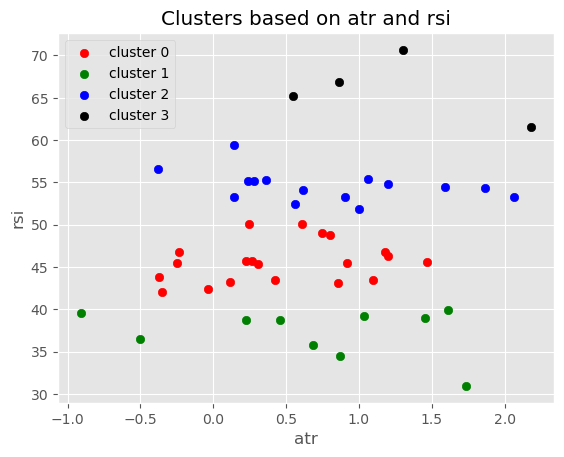

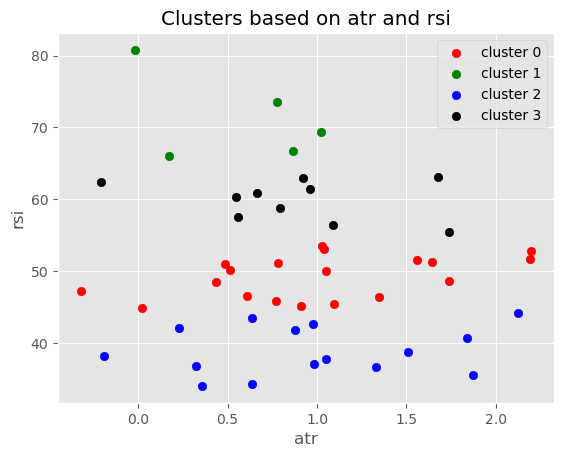

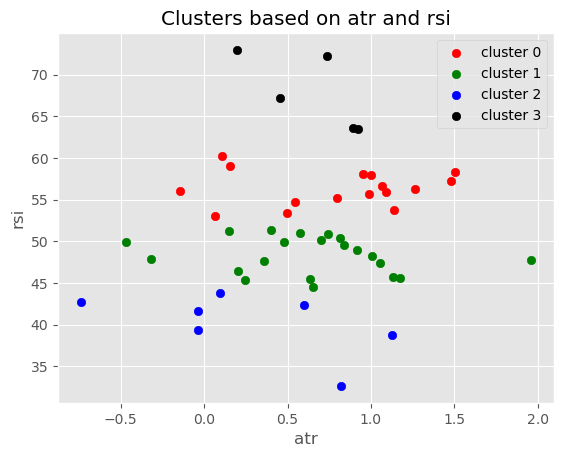

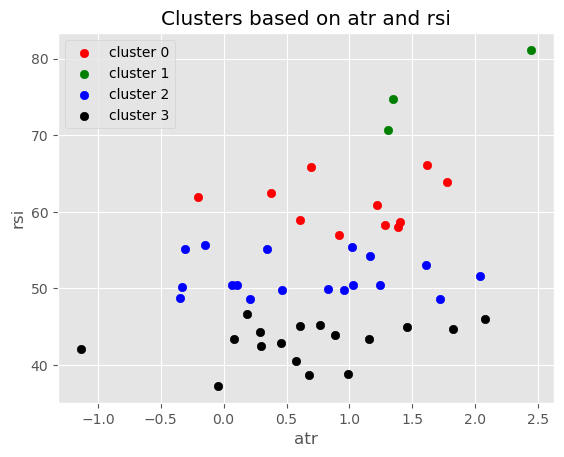

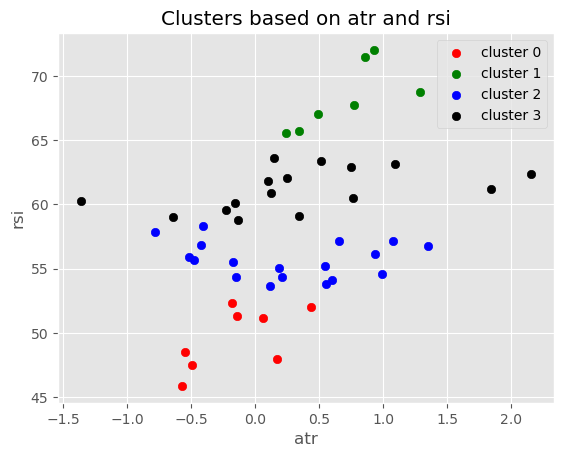

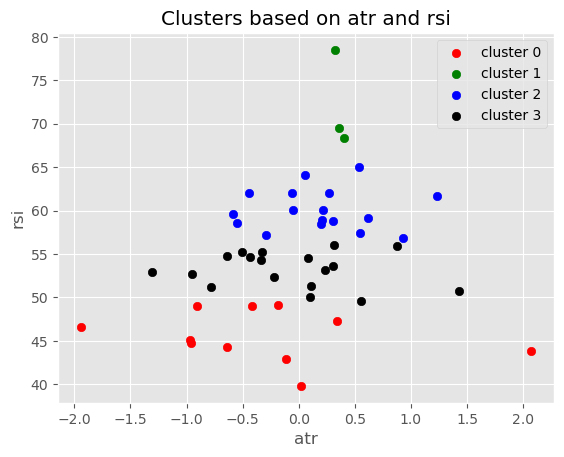

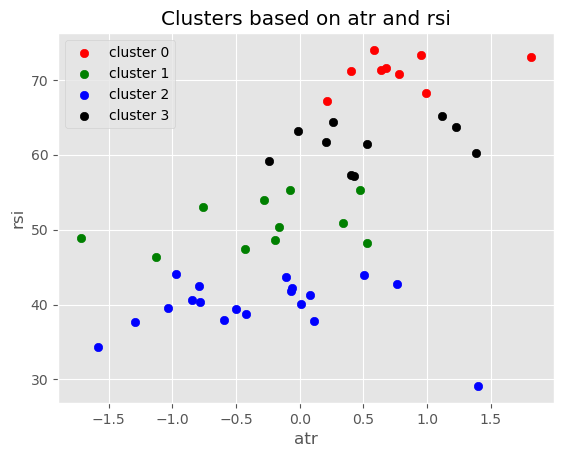

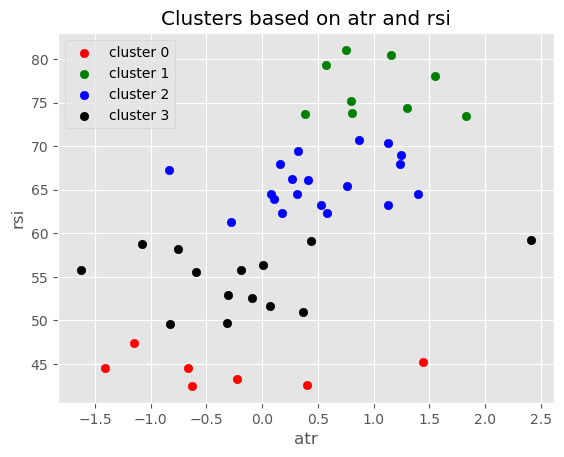

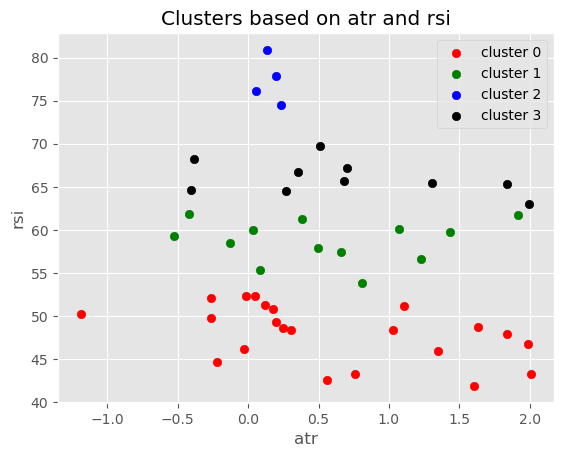

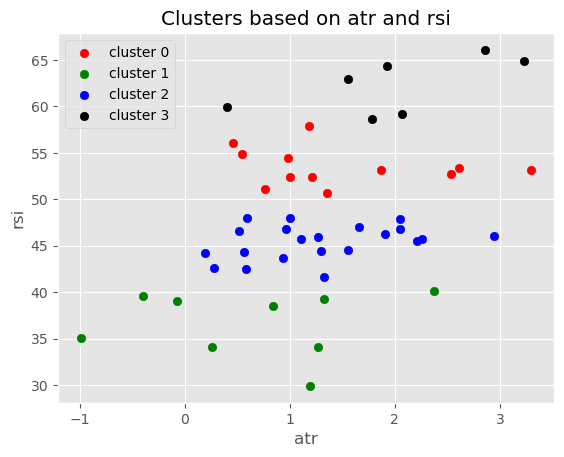

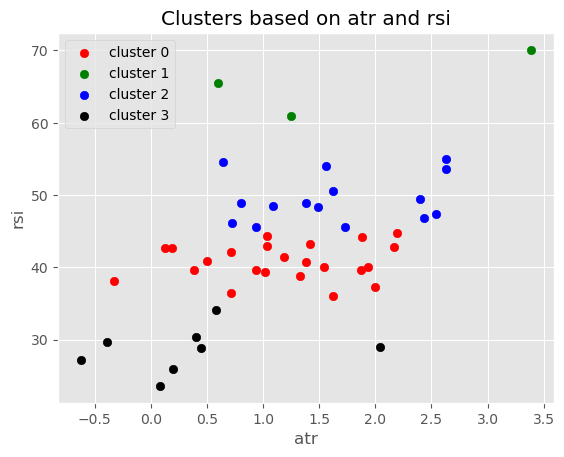

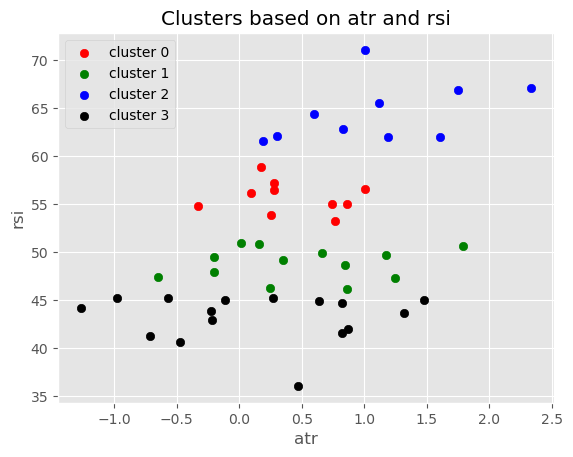

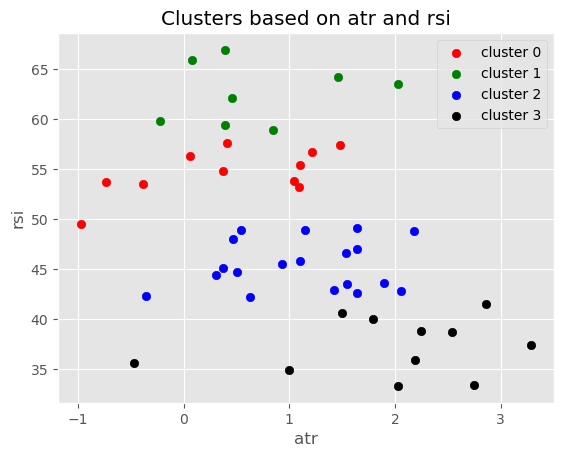

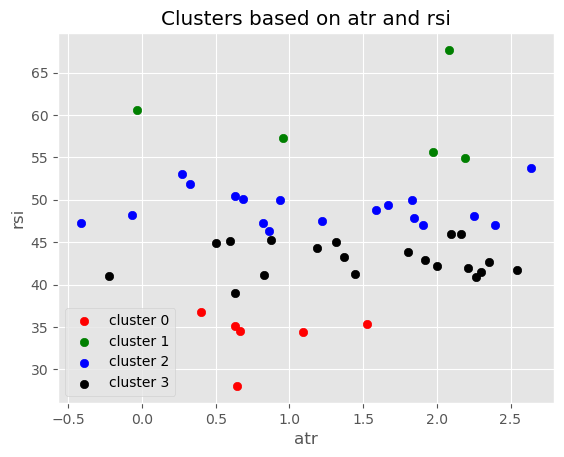

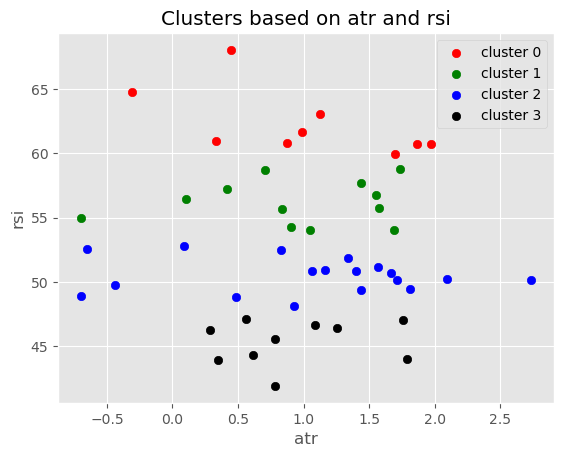

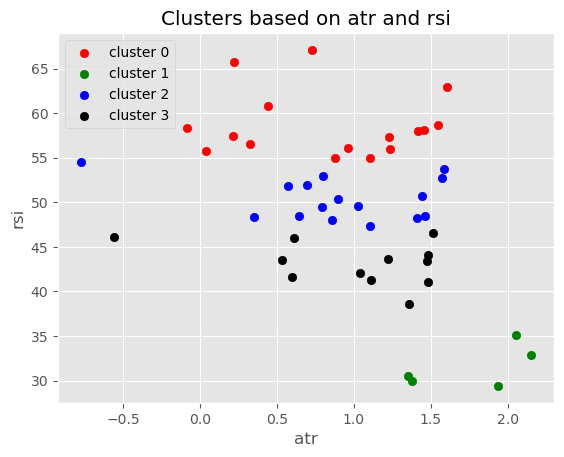

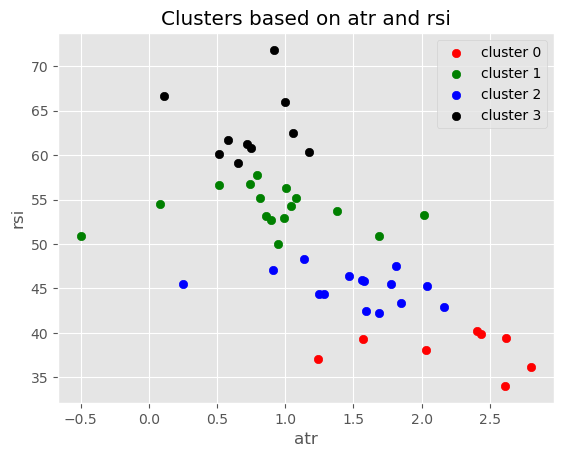

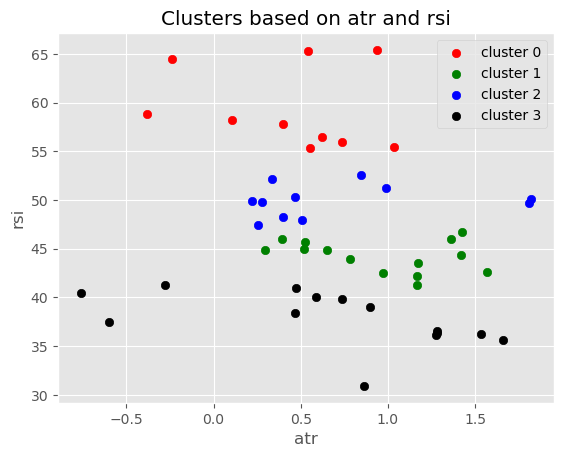

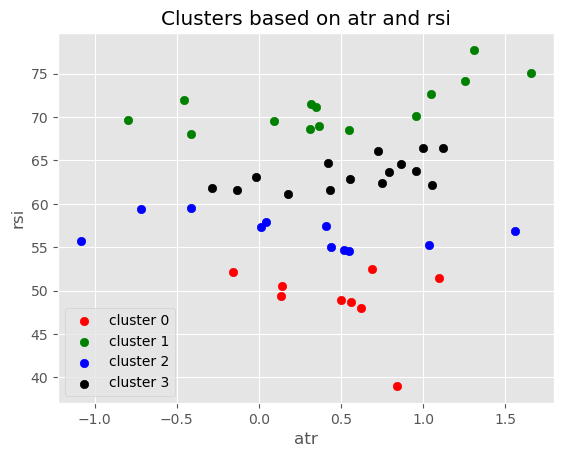

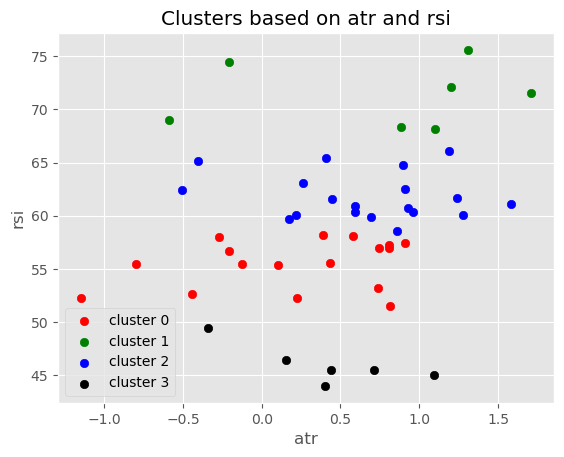

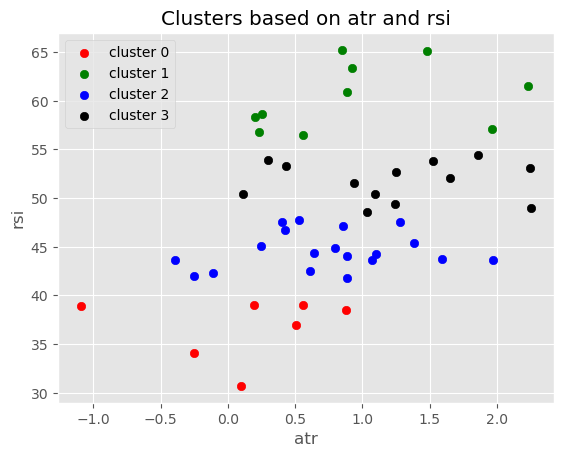

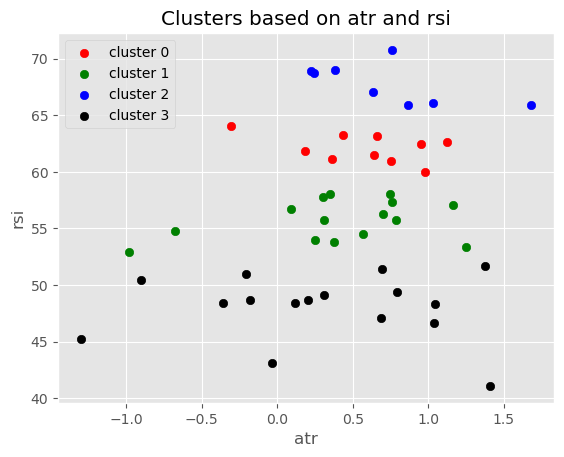

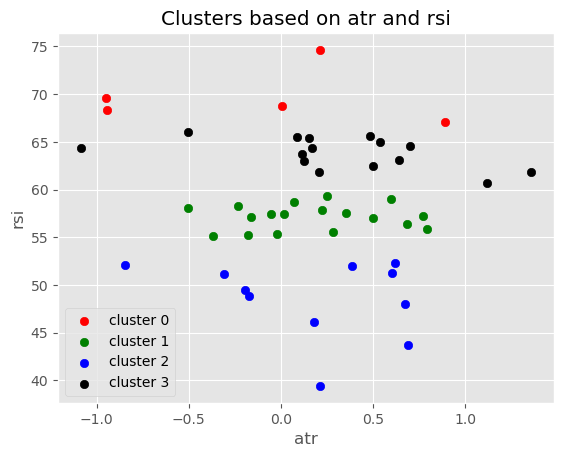

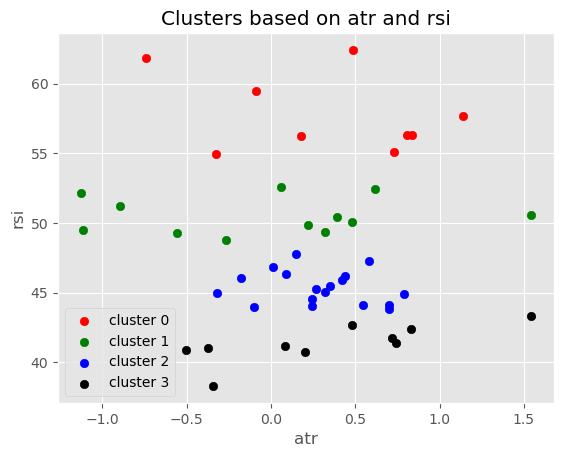

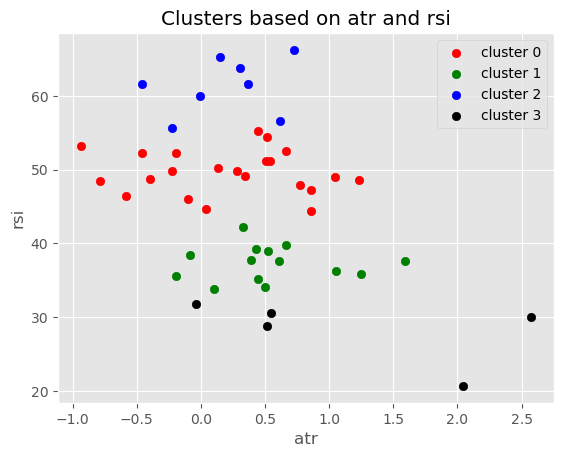

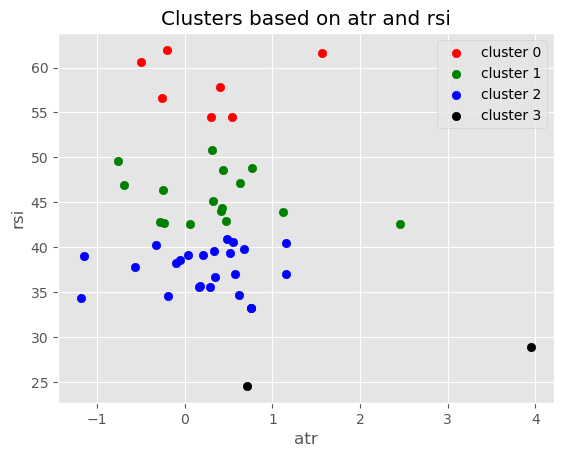

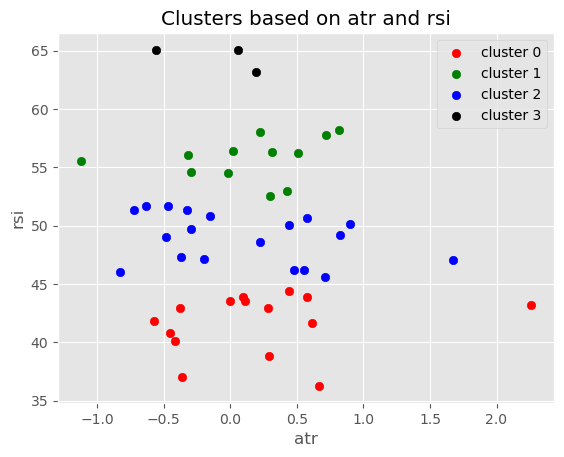

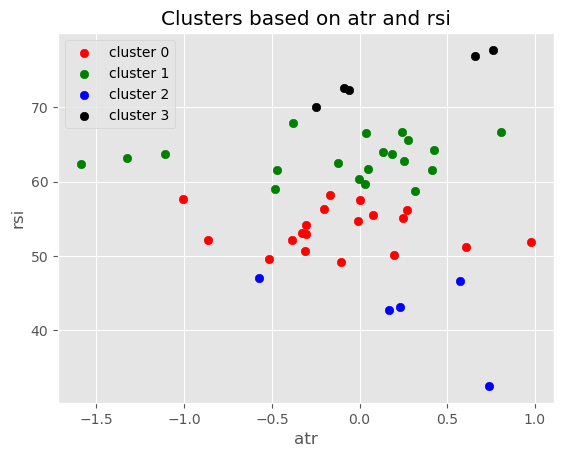

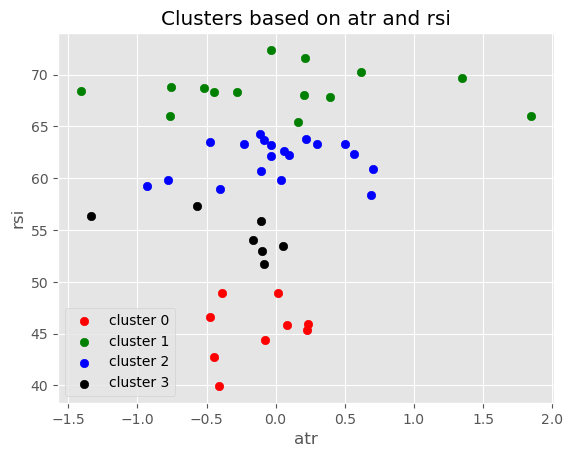

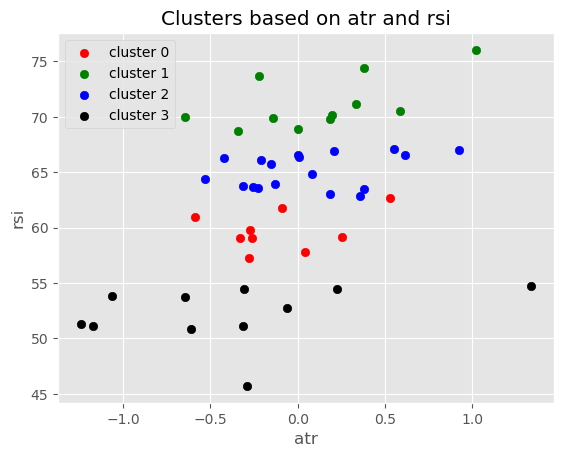

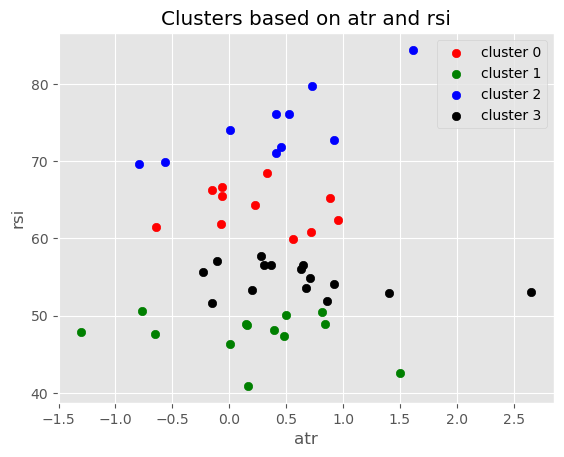

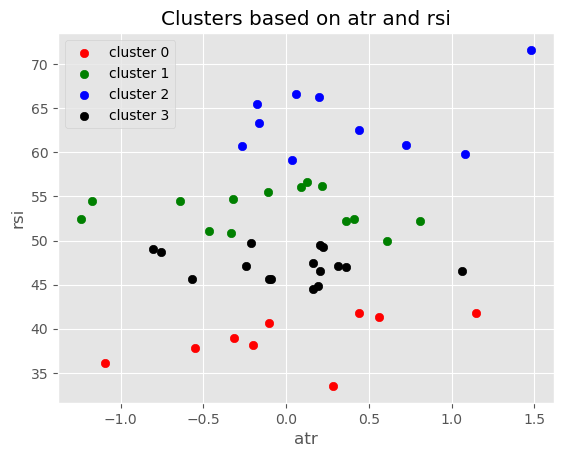

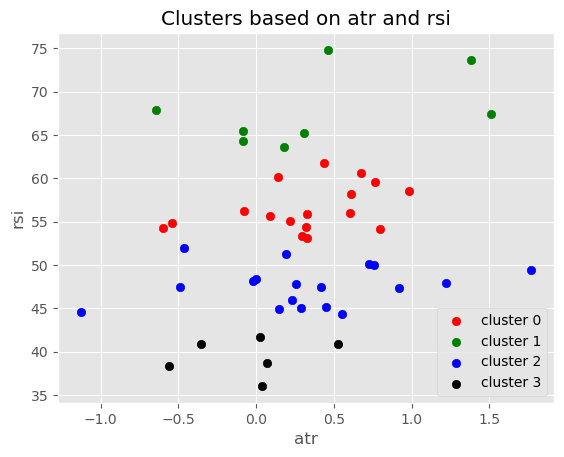

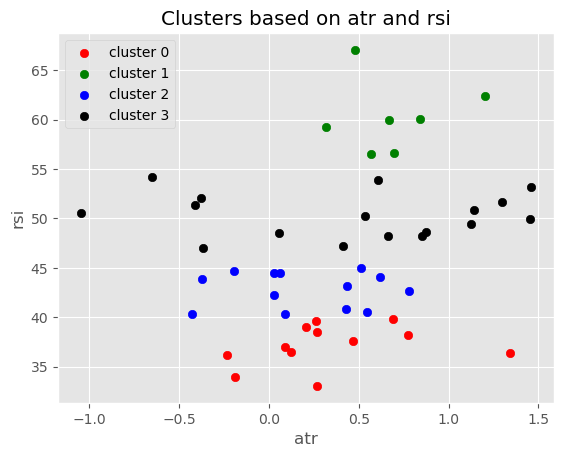

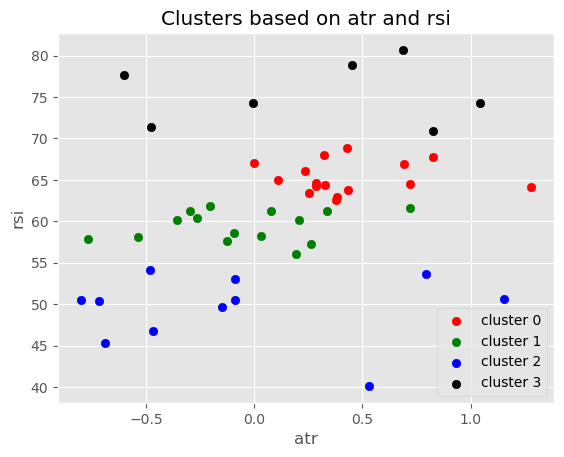

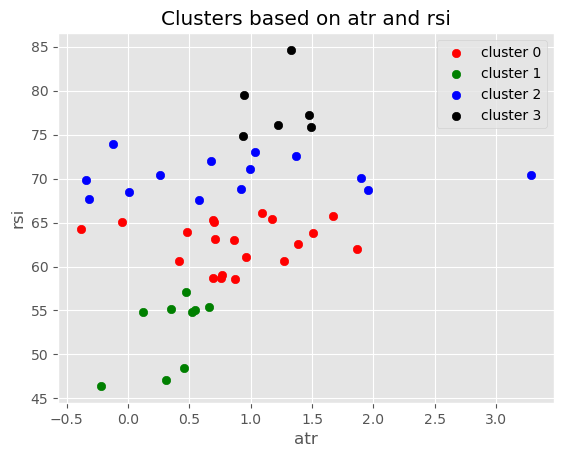

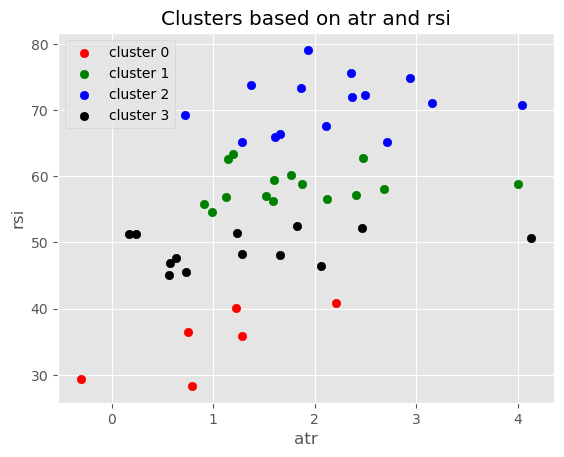

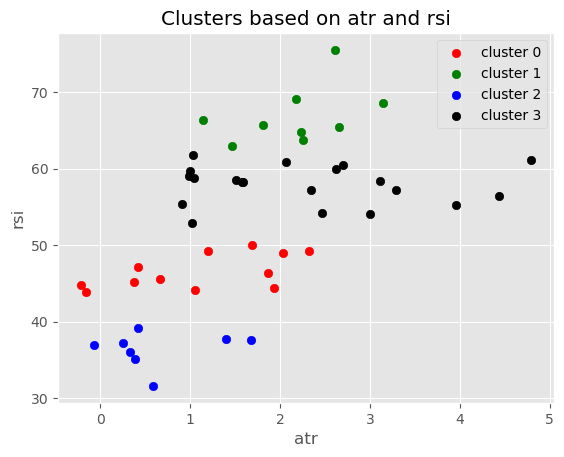

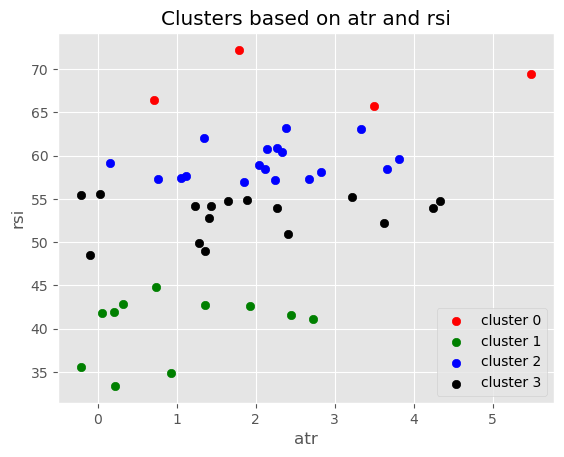

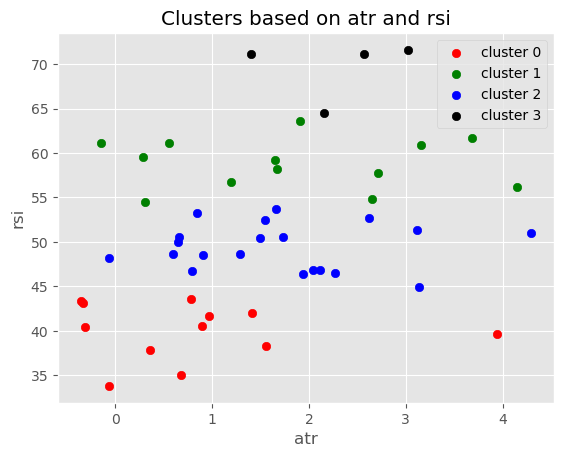

In [14]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

##  Apply pre-defined Centriods

In [15]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 1] = target_rsi_values

initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [16]:
 

data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                           
2017-06-30 ADANIENT.NS            0.000190  57.671203  4.182520  4.252703   
           ADANIPORTS.NS         -0.000611  55.352508  5.830071  5.858318   
           APOLLOHOSP.NS          0.000105  51.017366  7.100977  7.141823   
           ASIANPAINT.NS         -0.000339  42.566595  6.967230  6.998525   
           AXISBANK.NS            0.000268  54.685895  6.194448  6.221152   
...                                    ...        ...       ...       ...   
2024-04-30 TCS.NS                -0.000014  42.016696  8.235730  8.264381   
           TECHM.NS               0.000112  37.891556  7.070573  7.119534   
           TITAN.NS               0.000130  46.797476  8.169608  8.211308   
           ULTRACEMCO.NS          0.000085  48.645358  9.138886  9.180060   
           WIPRO.NS               0.000057  40.502965  6.101993  6.158039   

                           bb_high       atr      macd  return_1m  return_2m  \
date       ticker                                                              
2017-06-30 ADANIENT.NS    4.322886 -0.746783 -0.140024   0.135274   0.103210   
           ADANIPORTS.NS  5.886564 -0.892924  0.045400   0.070944   0.052555   
           APOLLOHOSP.NS  7.182669 -0.952959 -0.211768   0.052391   0.016607   
           ASIANPAINT.NS  7.029819 -1.046429 -0.287907  -0.040243  -0.006976   
           AXISBANK.NS    6.247856 -1.216675 -0.171695   0.006420   0.007526   
...                            ...       ...       ...        ...        ...   
2024-04-30 TCS.NS         8.293031  1.409188 -1.479978  -0.011673  -0.032777   
           TECHM.NS       7.168494  0.359230 -1.352911  -0.049996  -0.035220   
           TITAN.NS       8.253007  2.036742 -1.168752  -0.050516  -0.002023   
           ULTRACEMCO.NS  9.221235  1.291577 -0.969017  -0.009262  -0.011875   
           WIPRO.NS       6.214085  0.896825 -1.619500  -0.042075  -0.058294   

                          return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                       
2017-06-30 ADANIENT.NS     0.068984   0.095889   0.081151    0.035991   
           ADANIPORTS.NS   0.022507   0.051600   0.039244    0.047995   
           APOLLOHOSP.NS   0.030366   0.012944  -0.003331   -0.002632   
           ASIANPAINT.NS   0.009648   0.036498  -0.005188    0.008277   
           AXISBANK.NS     0.017716   0.023537  -0.005026   -0.001784   
...                             ...        ...        ...         ...   
2024-04-30 TCS.NS          0.001317   0.022452   0.013454    0.016061   
           TECHM.NS       -0.038437   0.009386   0.008004    0.015410   
           TITAN.NS       -0.007979   0.020835   0.020618    0.026631   
           ULTRACEMCO.NS  -0.016957   0.023096   0.016742    0.021057   
           WIPRO.NS       -0.012888   0.031871   0.014451    0.015104   

                            Mkt-RF       SMB       HML       RMW       CMA  \
date       ticker                                                            
2017-06-30 ADANIENT.NS    0.337507 -0.370782  0.175597  1.767549 -0.430027   
           ADANIPORTS.NS  0.241177  0.212301  0.442829  0.477193 -0.557421   
           APOLLOHOSP.NS  0.395156 -0.401291  0.222053 -0.234960 -1.400143   
           ASIANPAINT.NS  0.117394  0.215835  0.185982  0.454187 -0.271948   
           AXISBANK.NS    0.821948  0.221947  0.444211 -0.370440  0.026871   
...                            ...       ...       ...       ...       ...   
2024-04-30 TCS.NS         0.413854  0.098949 -0.101795 -0.112002  0.137264   
           TECHM.NS       0.705386 -0.476668  0.292511 -0.416311 -0.648934   
           TITAN.NS       0.376473  0.176135  0.305927  0.616734 -0.001162   
           ULTRACEMCO.NS  0.362569 -0.072014  0.660721  0.250283 -1.374793   
           WIPRO.NS       0.496787 -0.267074  0.263701 -0.117042 -0.609687   

                  

In [17]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,5] , cluster_0.iloc[:,1] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,5] , cluster_1.iloc[:,1] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,5] , cluster_2.iloc[:,1] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,5] , cluster_3.iloc[:,1] , color = 'black', label='cluster 3')

    plt.legend()
    plt.show()
    return

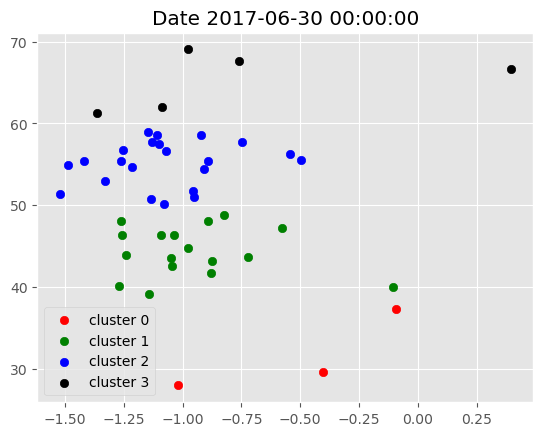

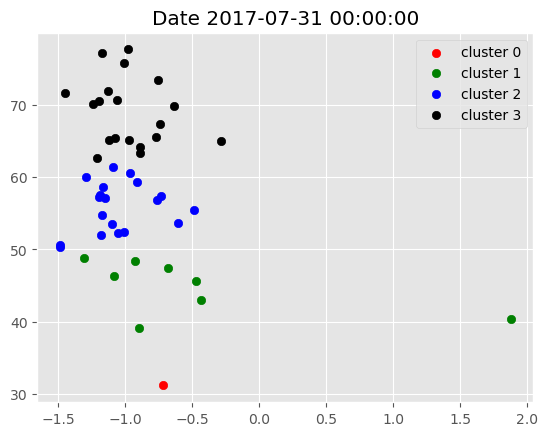

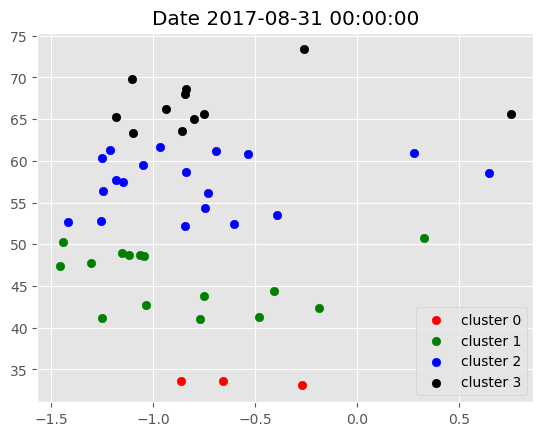

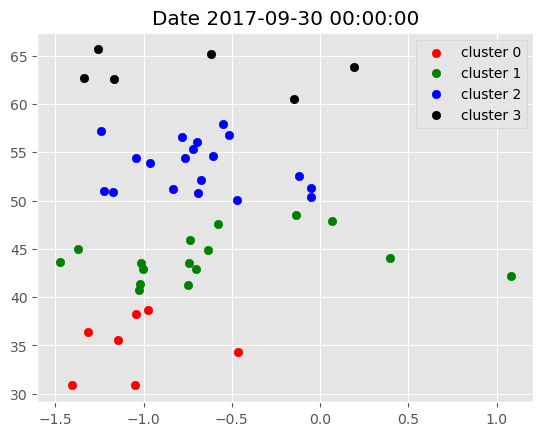

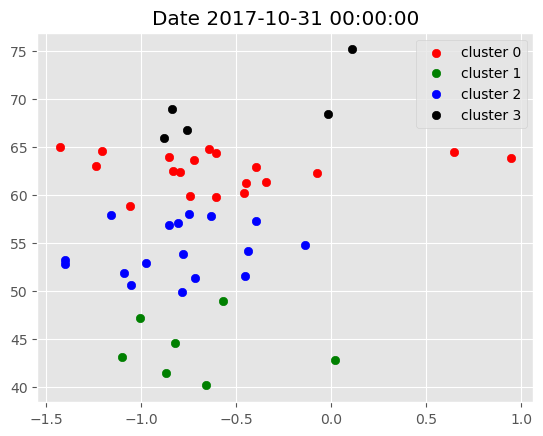

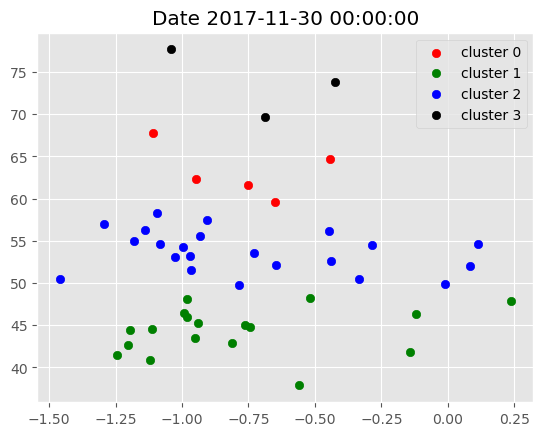

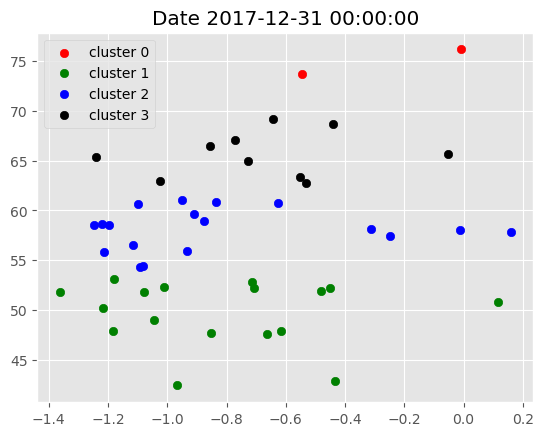

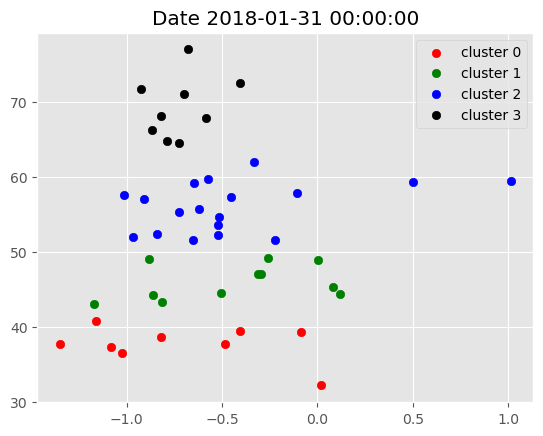

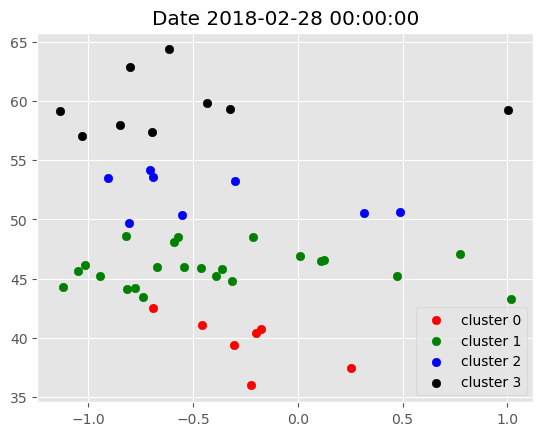

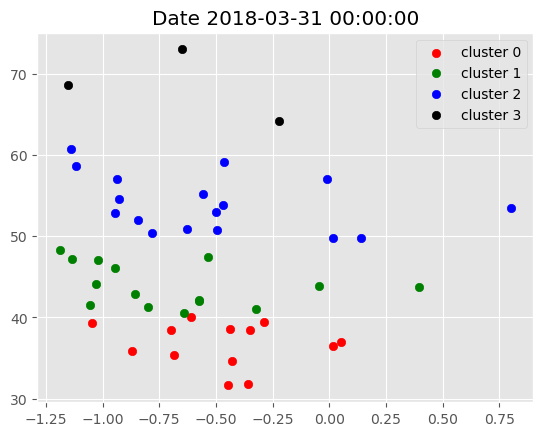

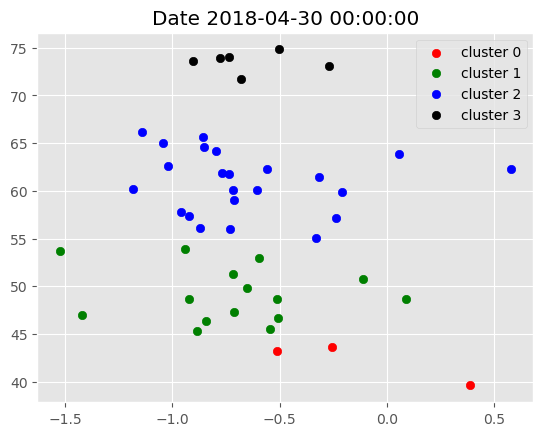

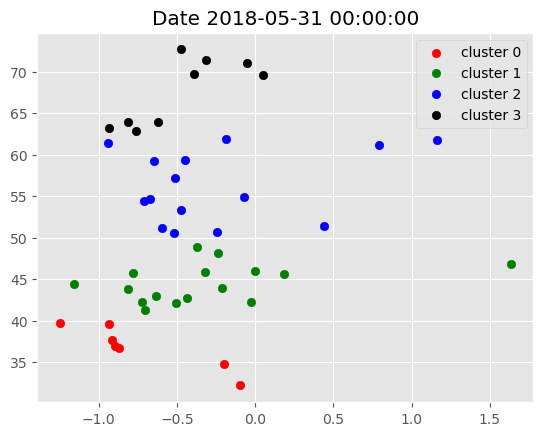

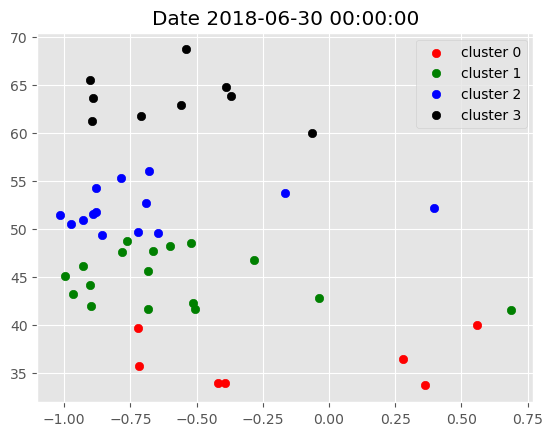

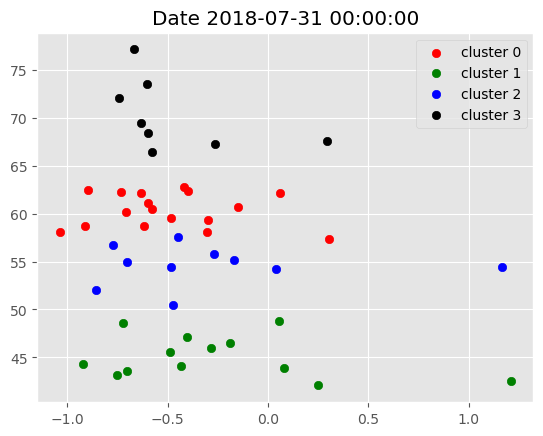

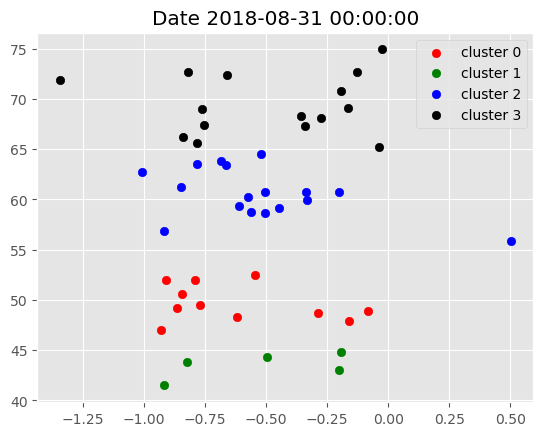

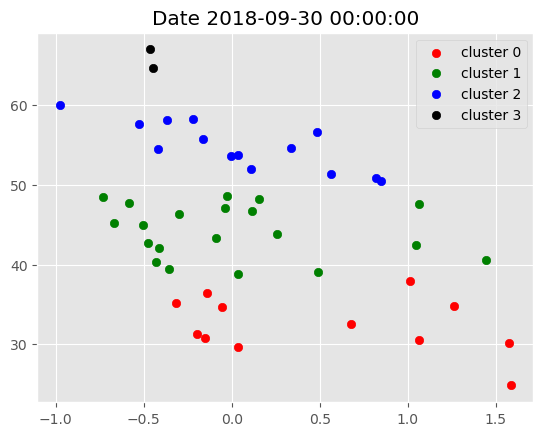

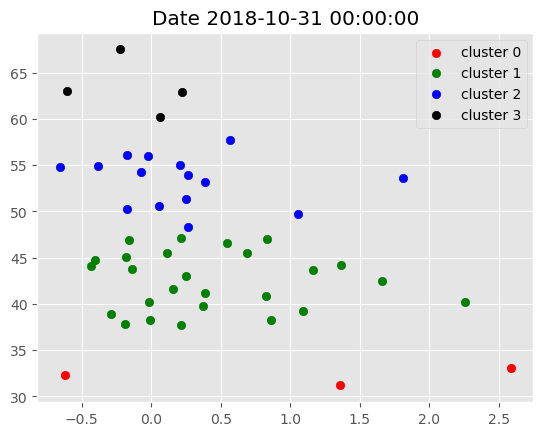

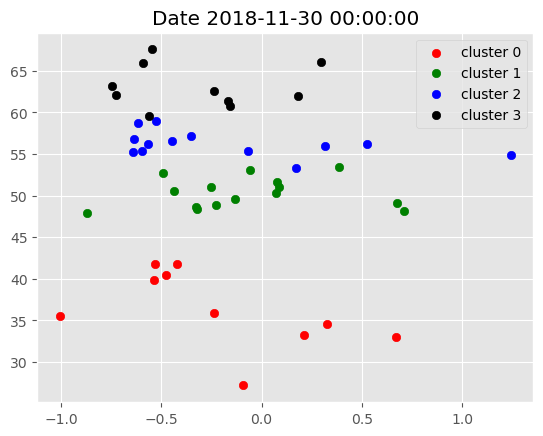

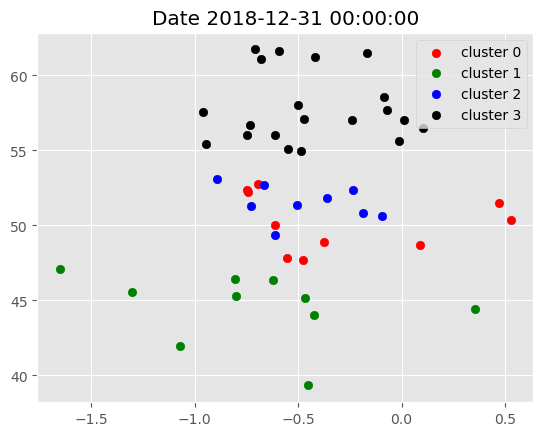

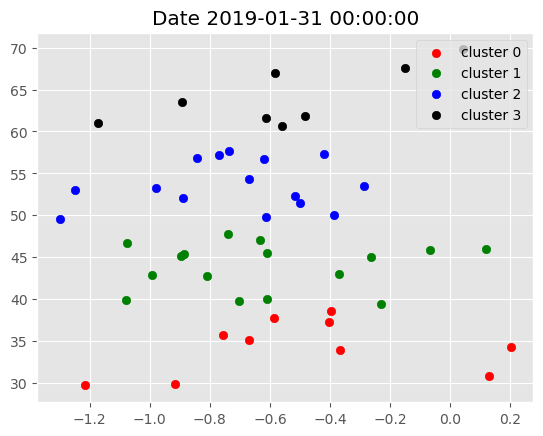

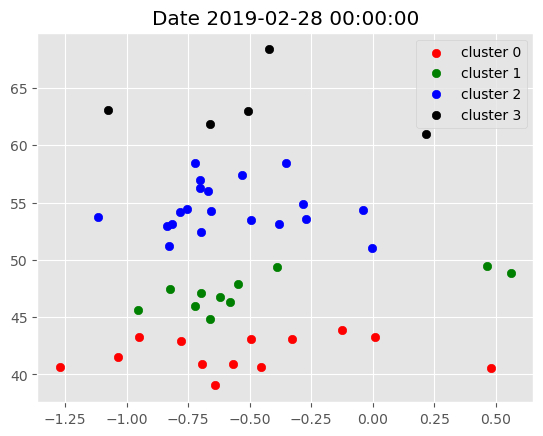

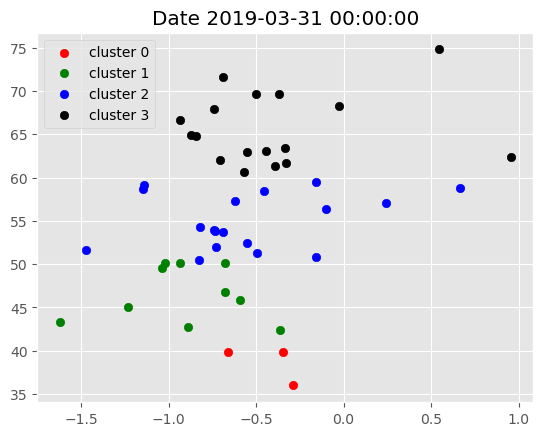

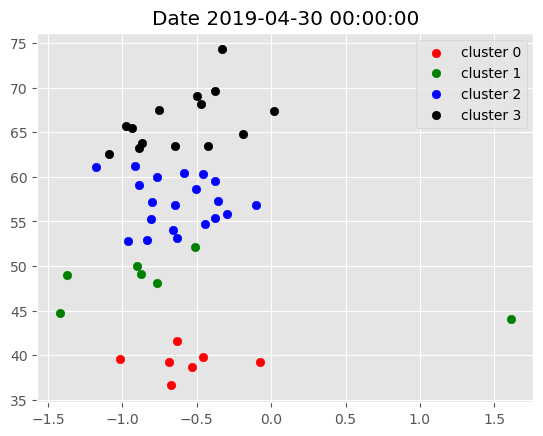

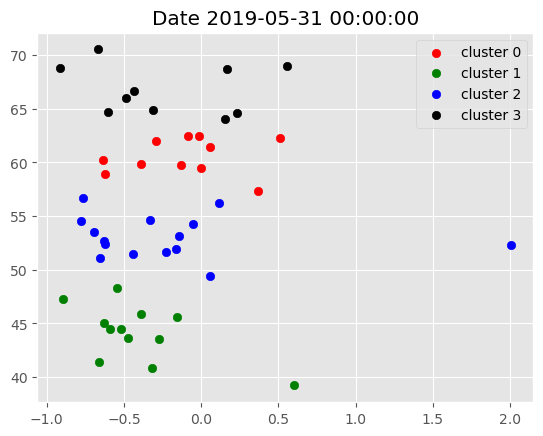

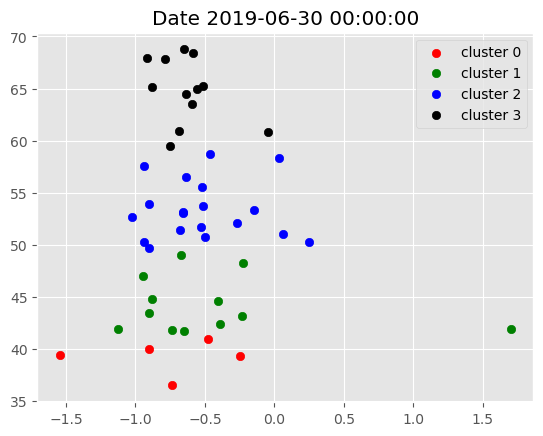

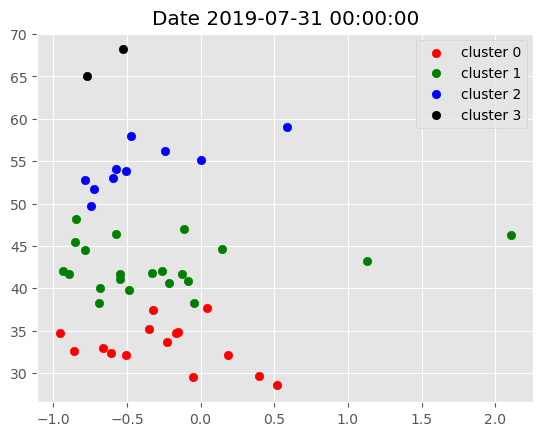

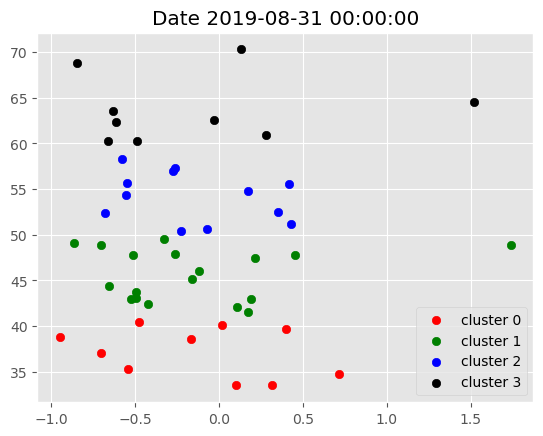

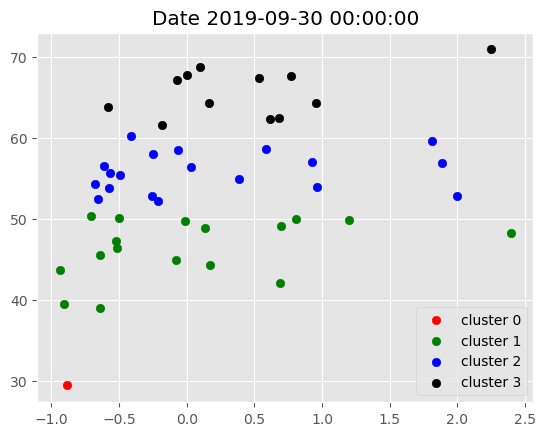

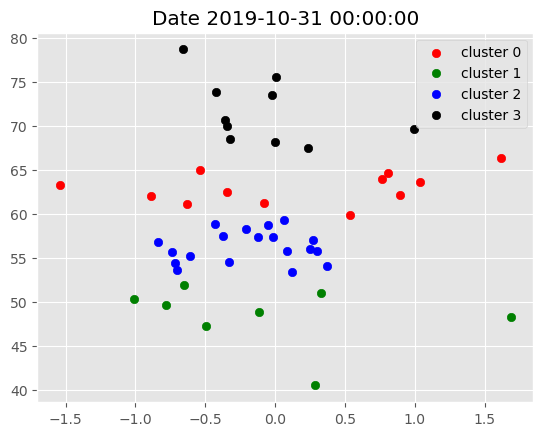

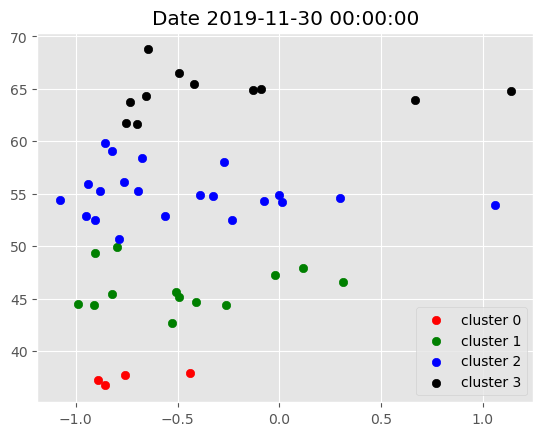

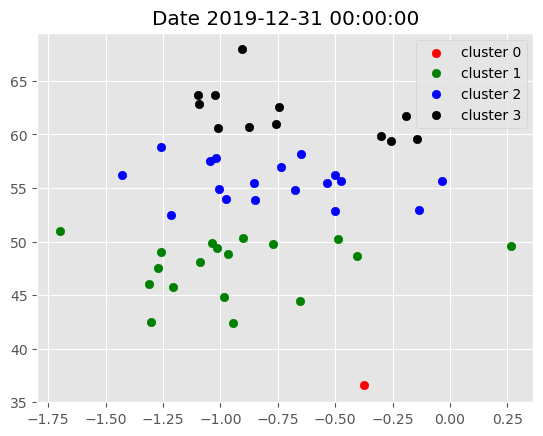

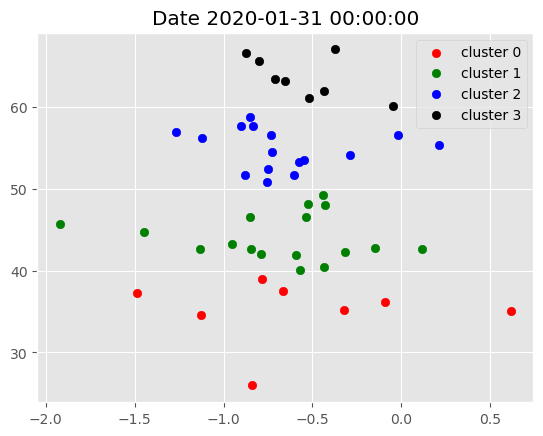

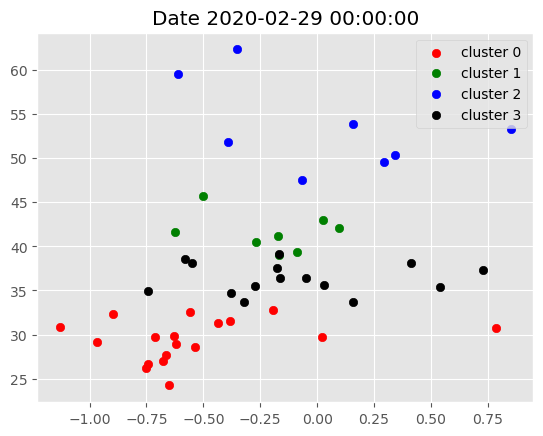

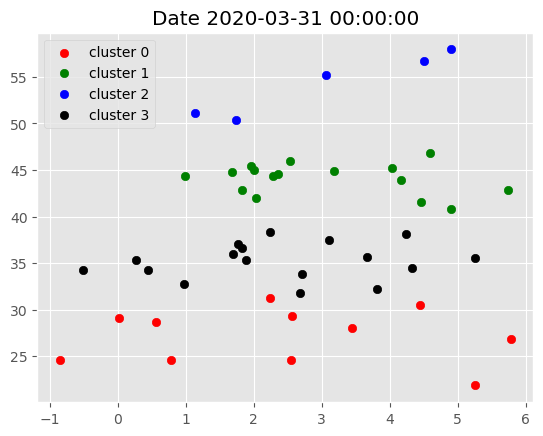

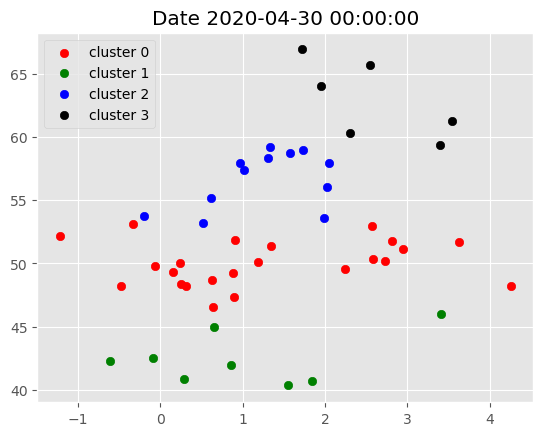

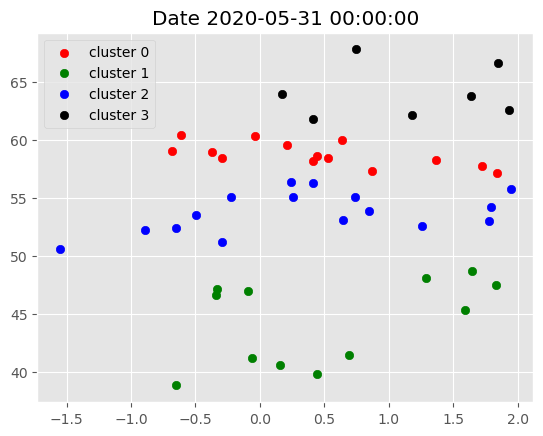

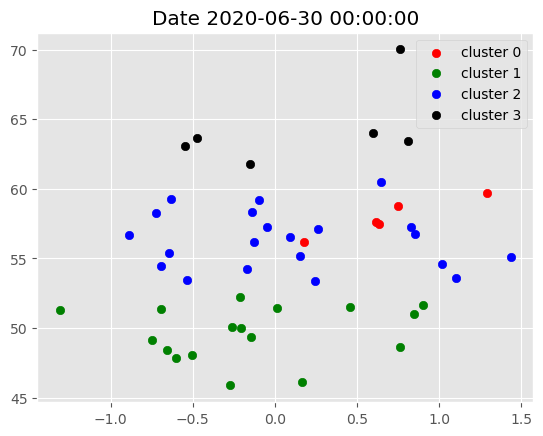

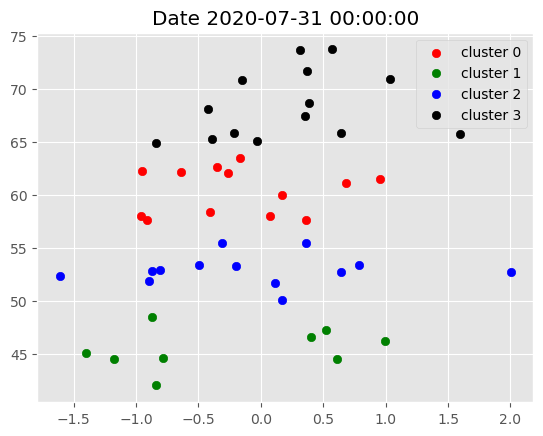

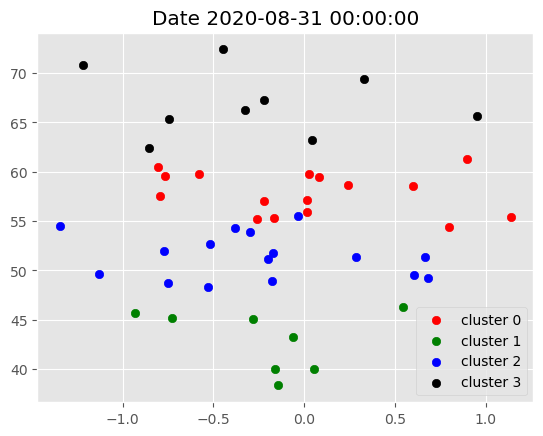

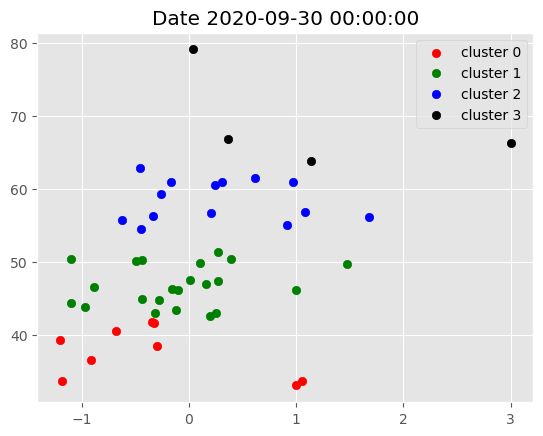

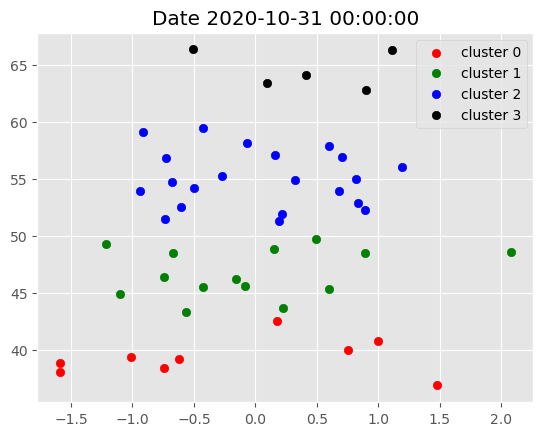

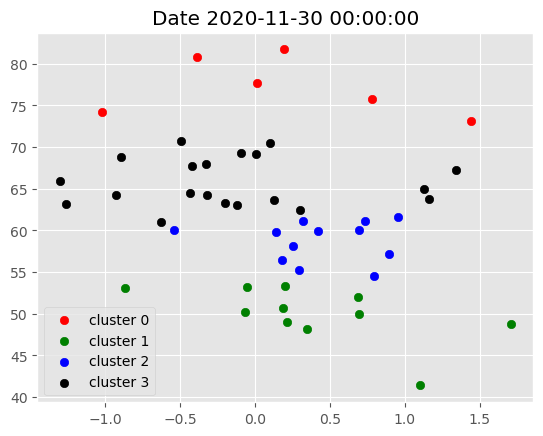

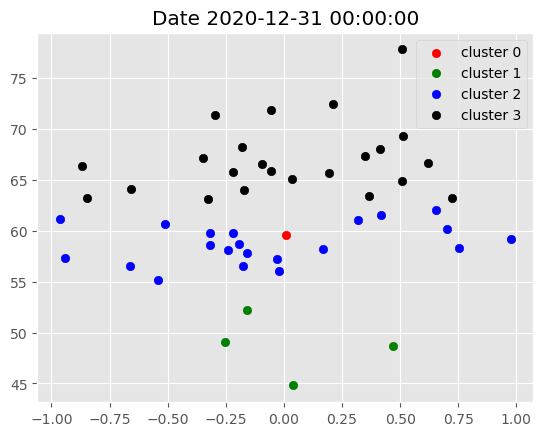

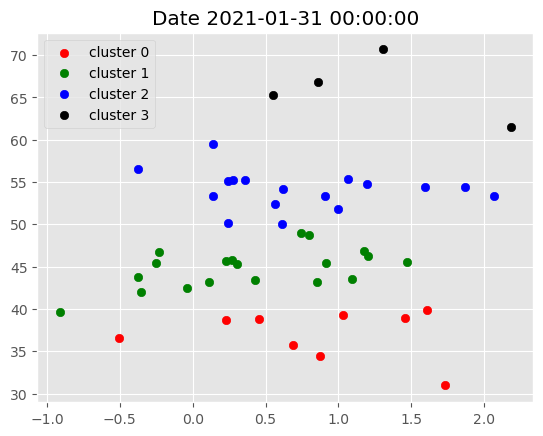

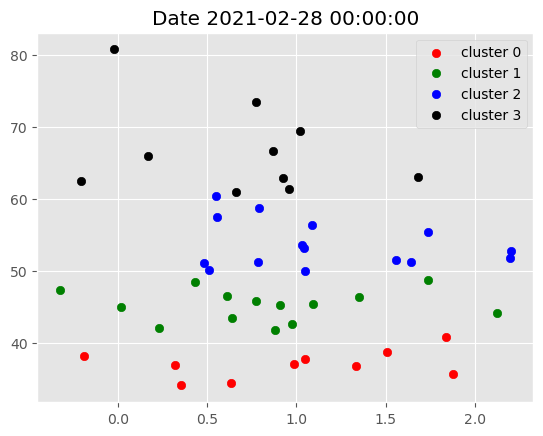

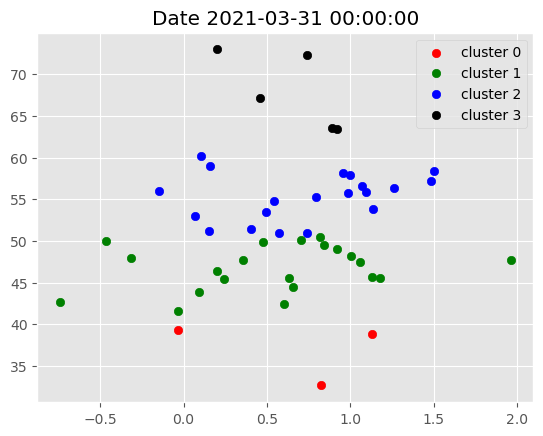

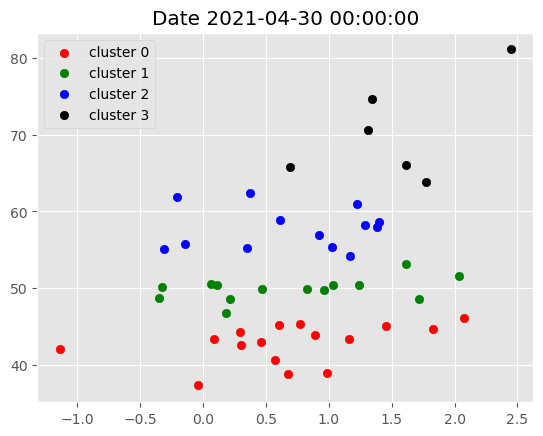

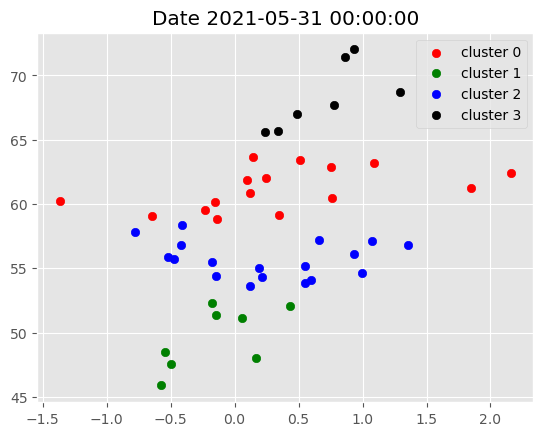

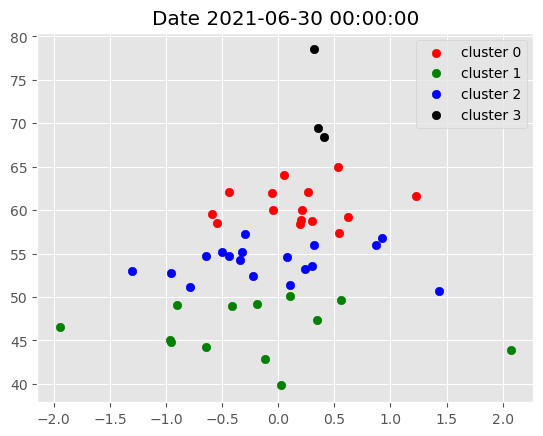

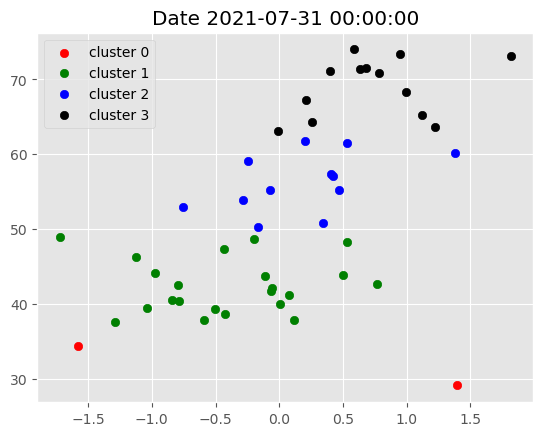

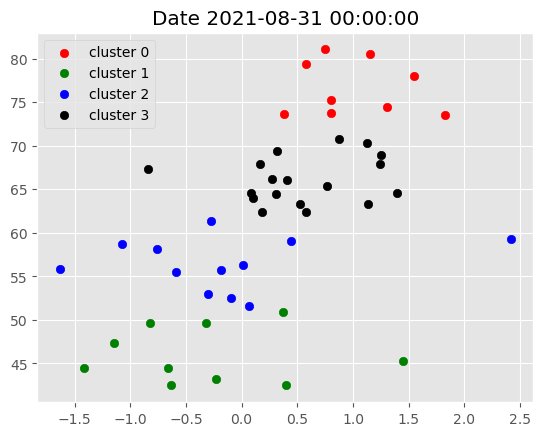

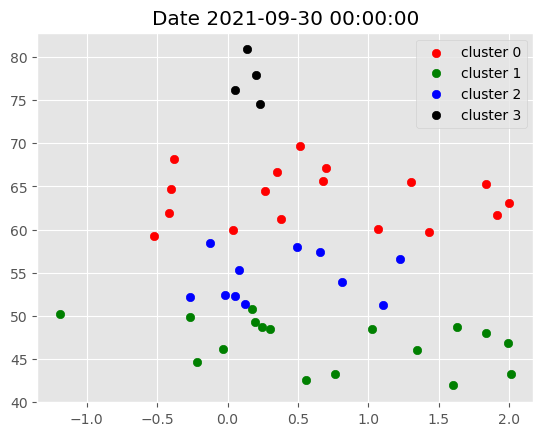

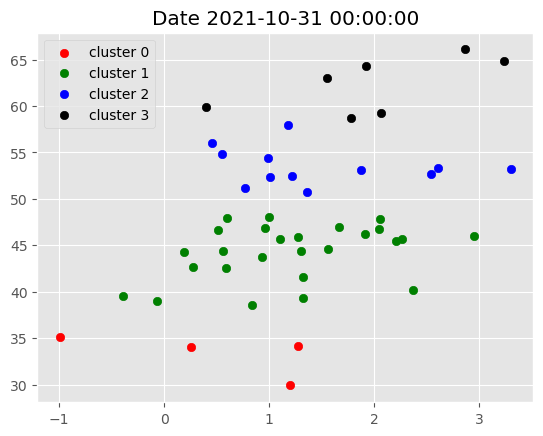

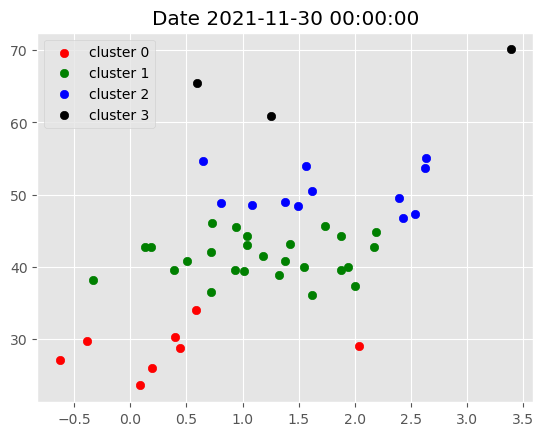

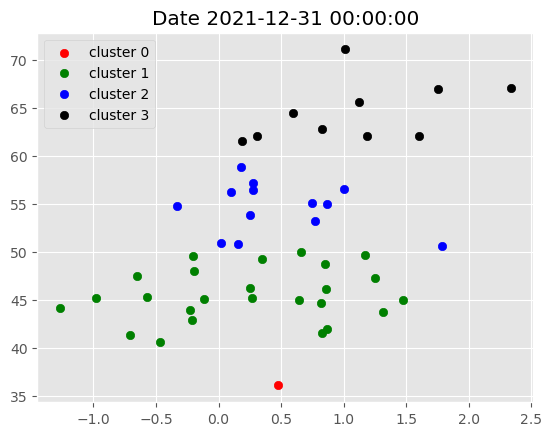

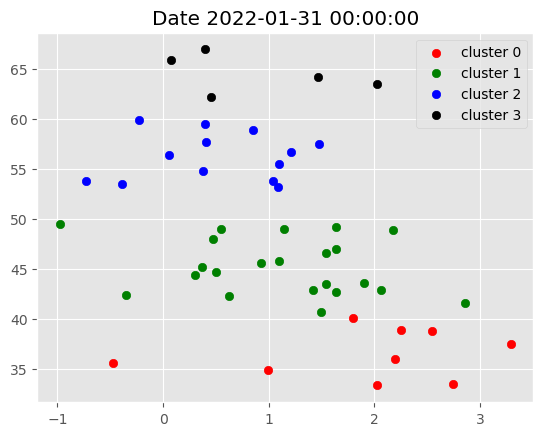

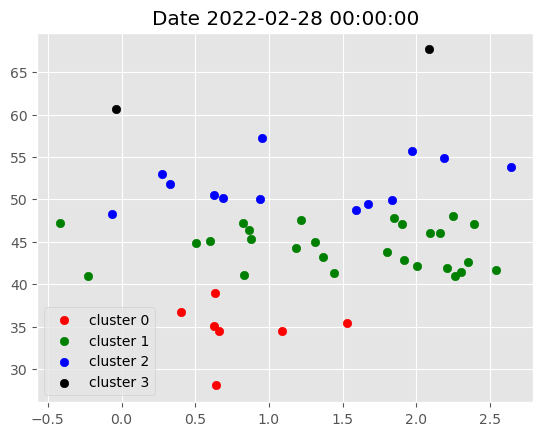

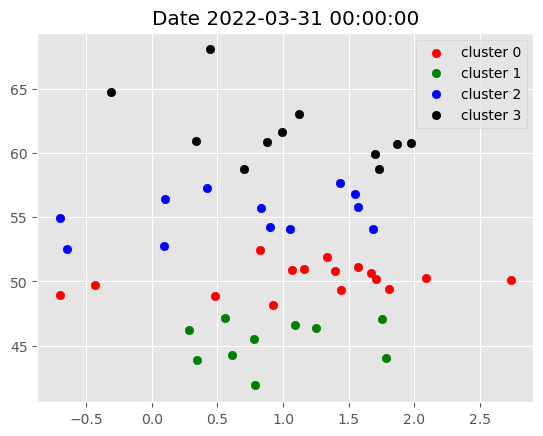

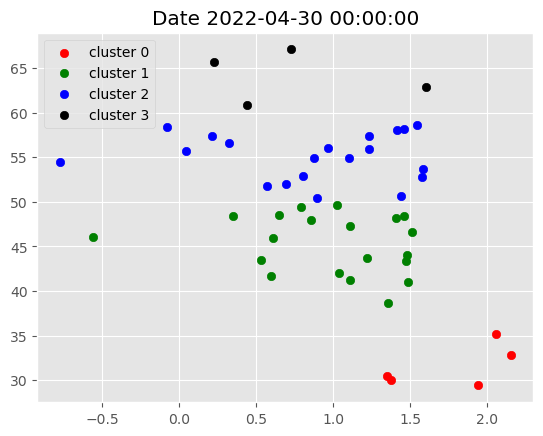

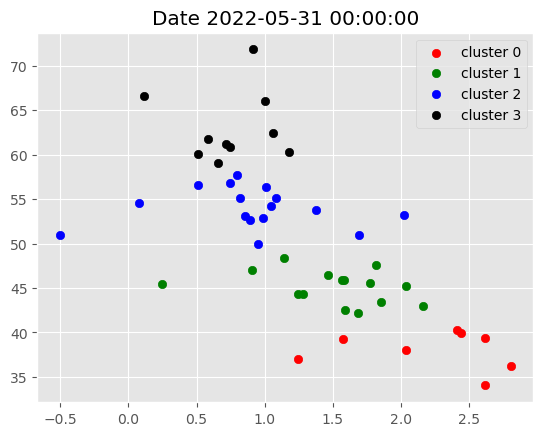

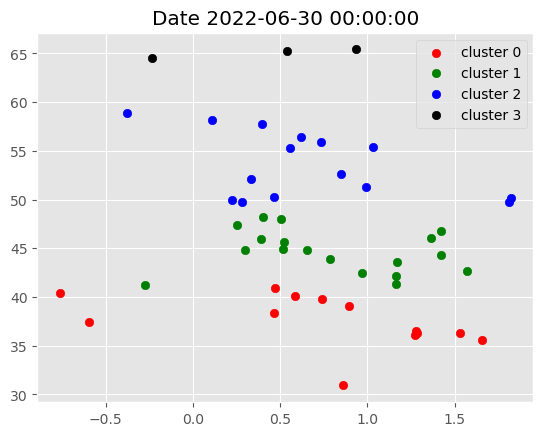

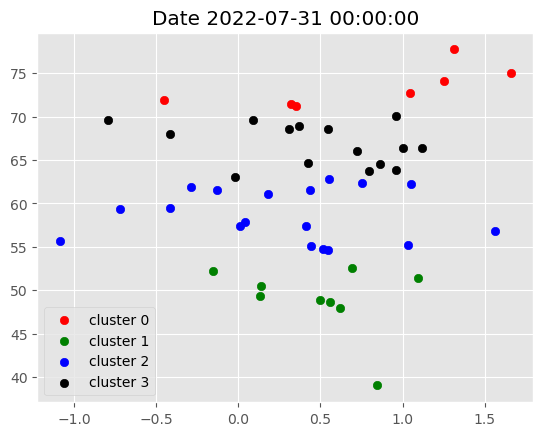

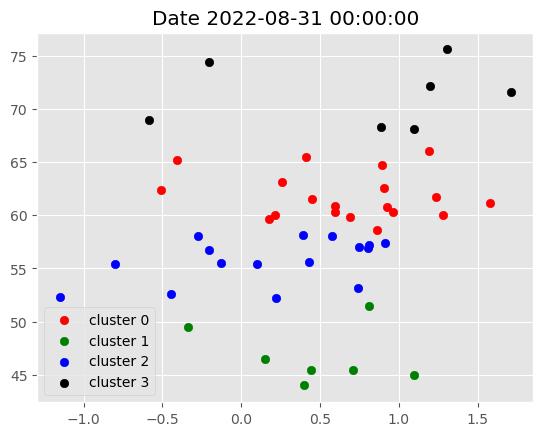

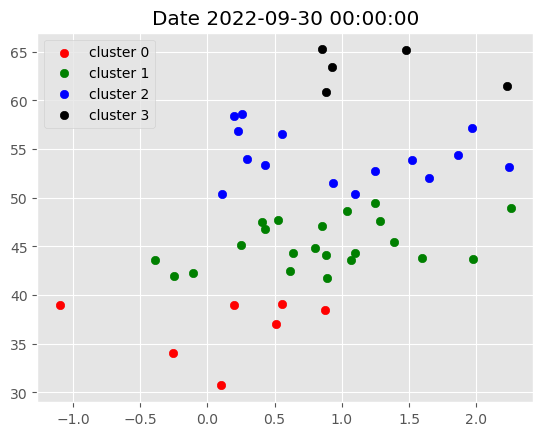

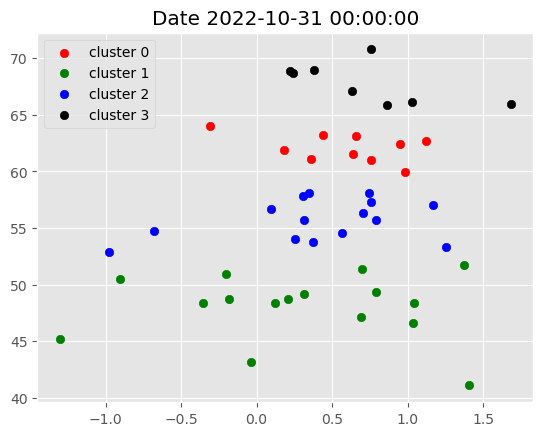

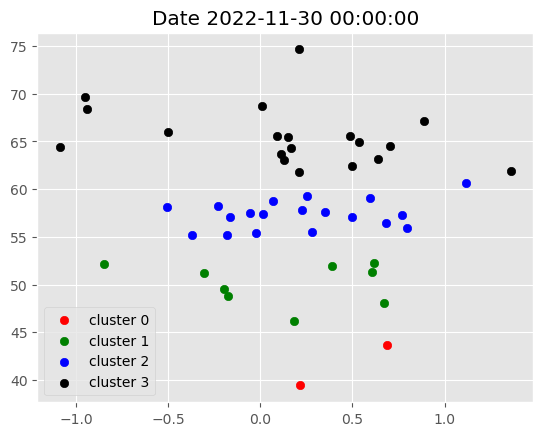

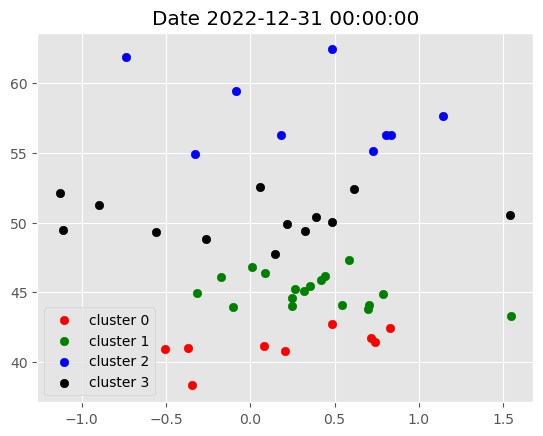

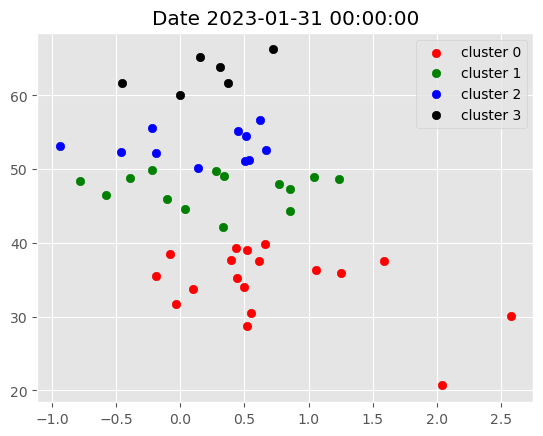

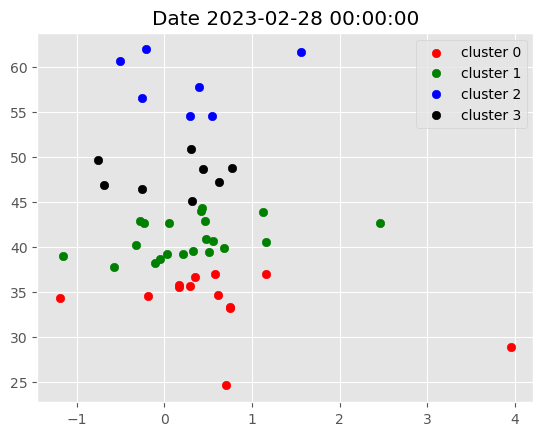

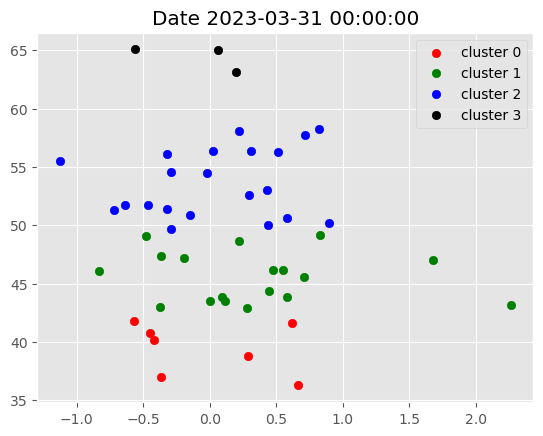

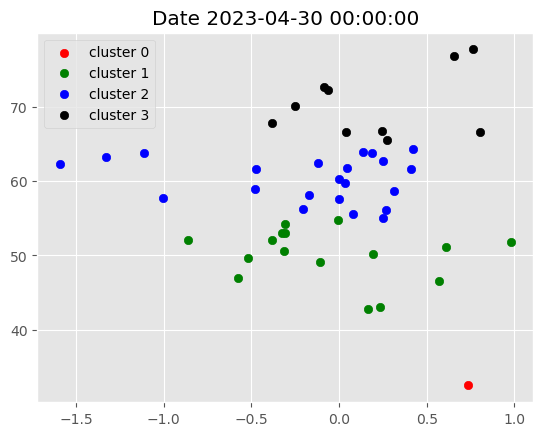

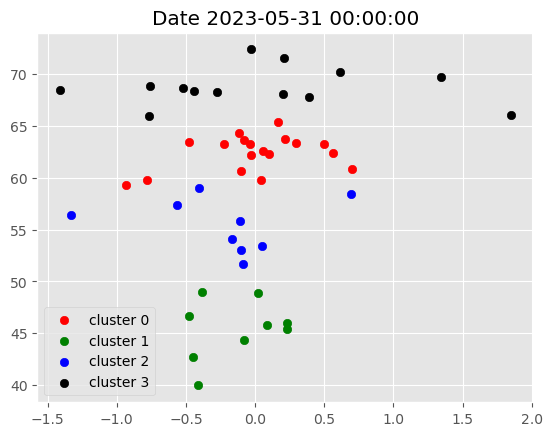

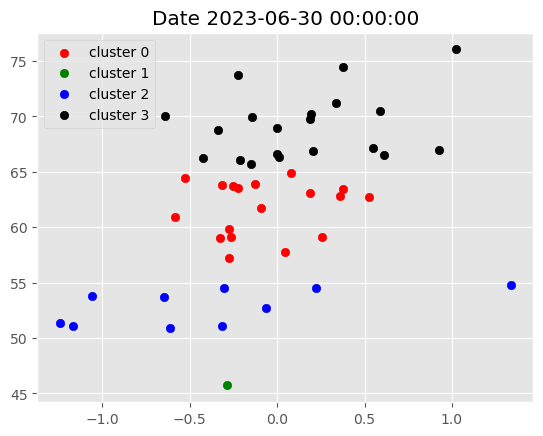

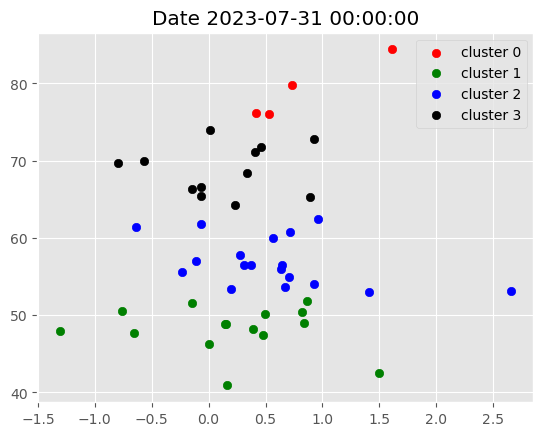

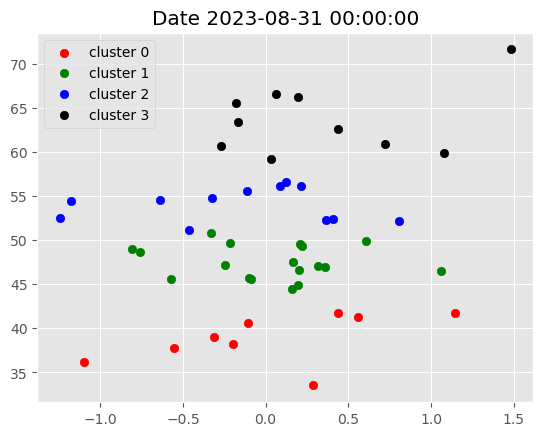

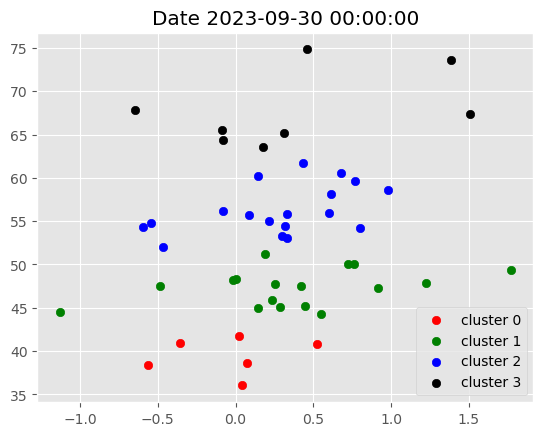

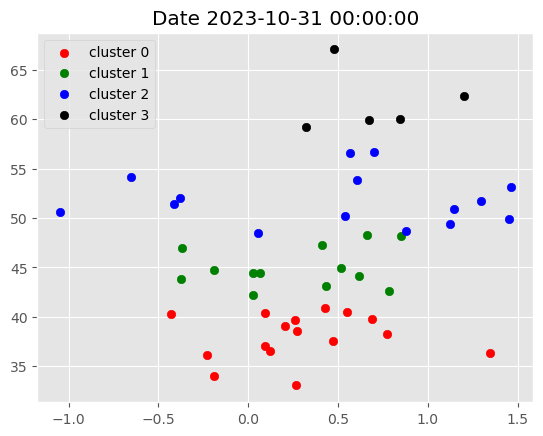

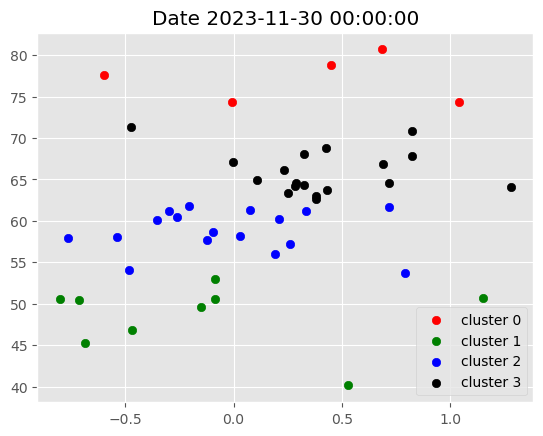

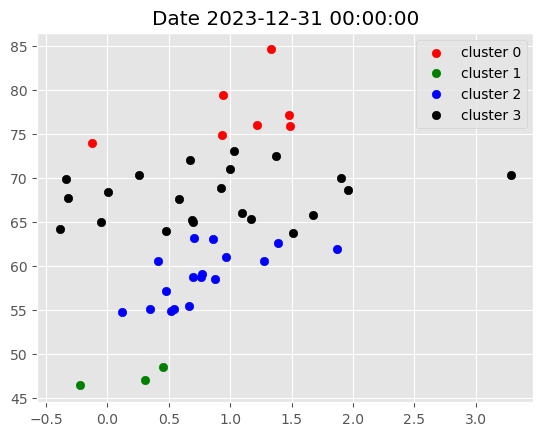

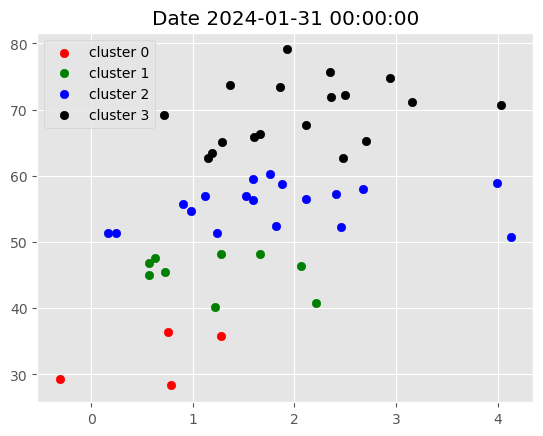

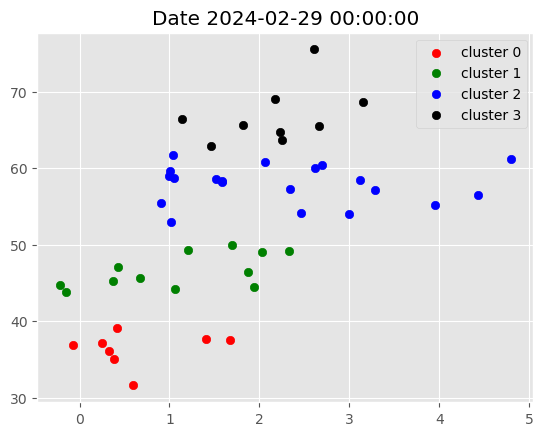

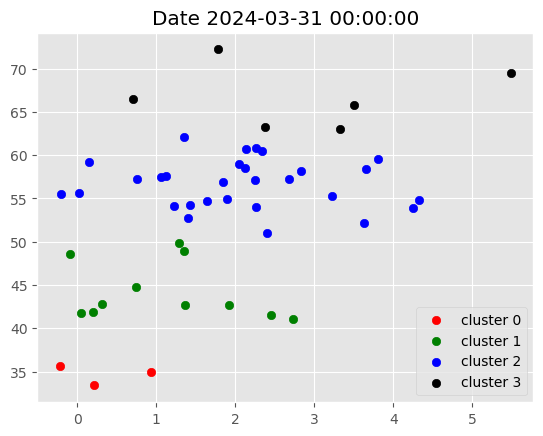

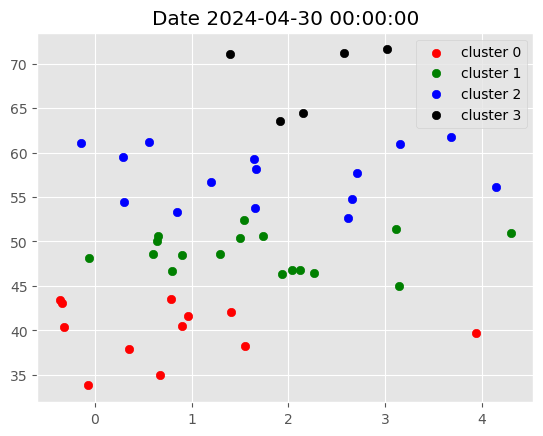

In [18]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

In [19]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 1] = target_rsi_values

initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

# 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization
* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.

In [20]:
filtered_df = data[data['cluster']==0].copy()  # eveything lies here so use cluster value carefully

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {} # declare dictionary

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2017-07-01': ['BPCL.NS', 'COALINDIA.NS', 'ONGC.NS'],
 '2017-08-01': ['DRREDDY.NS'],
 '2017-09-01': ['APOLLOHOSP.NS', 'DRREDDY.NS', 'TATAMOTORS.NS'],
 '2017-10-01': ['APOLLOHOSP.NS',
  'ASIANPAINT.NS',
  'ICICIBANK.NS',
  'ITC.NS',
  'M&M.NS',
  'SBIN.NS',
  'ULTRACEMCO.NS'],
 '2017-11-01': ['BAJAJ-AUTO.NS',
  'BPCL.NS',
  'BRITANNIA.NS',
  'CIPLA.NS',
  'COALINDIA.NS',
  'GRASIM.NS',
  'HINDALCO.NS',
  'ICICIBANK.NS',
  'LT.NS',
  'LTIM.NS',
  'MARUTI.NS',
  'NTPC.NS',
  'SBIN.NS',
  'SHRIRAMFIN.NS',
  'SUNPHARMA.NS',
  'TCS.NS',
  'TECHM.NS',
  'TITAN.NS',
  'ULTRACEMCO.NS'],
 '2017-12-01': ['BAJAJ-AUTO.NS',
  'BRITANNIA.NS',
  'DIVISLAB.NS',
  'MARUTI.NS',
  'SHRIRAMFIN.NS'],
 '2018-01-01': ['MARUTI.NS', 'TATACONSUM.NS'],
 '2018-02-01': ['ASIANPAINT.NS',
  'BAJAJFINSV.NS',
  'BHARTIARTL.NS',
  'DRREDDY.NS',
  'EICHERMOT.NS',
  'NESTLEIND.NS',
  'NTPC.NS',
  'POWERGRID.NS',
  'TATAMOTORS.NS'],
 '2018-03-01': ['AXISBANK.NS',
  'BAJAJ-AUTO.NS',
  'BHARTIARTL.NS',
  'BPCL.NS',
  'ICICI

# Define portfolio optimization function
* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [21]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

In [22]:
stocks = data.index.get_level_values('ticker').unique().tolist()
new_df= yf.download(tickers= stocks,
                    start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12)
                    ,end=data.index.get_level_values('date').unique()[-1])
new_df

[*********************100%%**********************]  50 of 50 completed


Adj Close                                            \
            ADANIENT.NS ADANIPORTS.NS APOLLOHOSP.NS ASIANPAINT.NS   
Date                                                                
2016-06-30    46.316601    198.655685   1283.162231    955.406006   
2016-07-01    45.195393    196.206696   1297.159058    954.644226   
2016-07-04    45.916168    204.802155   1310.473755    952.644470   
2016-07-05    45.168701    206.050613   1312.229492    938.074951   
2016-07-07    44.661484    201.728912   1323.885742    940.550781   
...                 ...           ...           ...           ...   
2024-04-23  3065.100098   1322.099976   6194.899902   2874.899902   
2024-04-24  3043.550049   1320.500000   6283.350098   2867.750000   
2024-04-25  3115.250000   1330.550049   6384.100098   2861.449951   
2024-04-26  3080.399902   1324.599976   6258.600098   2844.149902   
2024-04-29  3081.199951   1317.250000   5968.350098   2868.199951   

                                                                   \
            AXISBANK.NS BAJAJ-AUTO.NS BAJAJFINSV.NS BAJFINANCE.NS   
Date                                                                
2016-06-30   521.439026   2181.862305    231.527313    784.896301   
2016-07-01   530.626465   2166.694824    234.838272    801.631287   
2016-07-04   531.554932   2151.729736    234.534088    805.277710   
2016-07-05   527.498779   2118.757568    230.834167    801.906067   
2016-07-07   534.947083   2117.459961    231.746719    794.608459   
...                 ...           ...           ...           ...   
2024-04-23  1055.750000   8795.799805   1621.099976   7259.899902   
2024-04-24  1063.250000   8697.099609   1630.349976   7329.149902   
2024-04-25  1127.000000   8734.900391   1655.550049   7294.899902   
2024-04-26  1130.300049   8974.299805   1597.349976   6731.200195   
2024-04-29  1159.250000   8760.099609   1595.650024   6826.600098   

                                      ...        Volume               \
           BHARTIARTL.NS     BPCL.NS  ... SHRIRAMFIN.NS SUNPHARMA.NS   
Date                                  ...                              
2016-06-30    317.505188  231.691437  ...     2855747.0      4538392   
2016-07-01    318.846863  235.970230  ...      719403.0      2656477   
2016-07-04    323.174927  239.038849  ...      568607.0      1575107   
2016-07-05    316.726135  237.266830  ...      340116.0      2746347   
2016-07-07    314.518860  240.756836  ...      548185.0      2515212   
...                  ...         ...  ...           ...          ...   
2024-04-23   1342.349976  593.000000  ...      578517.0      9160422   
2024-04-24   1336.400024  593.349976  ...     1691860.0      4652803   
2024-04-25   1338.699951  603.400024  ...     2917532.0      3846327   
2024-04-26   1326.000000  609.450012  ...     4162052.0      1794350   
2024-04-29   1332.449951  618.799988  ...     2380923.0      1091667   

                                                                        \
           TATACONSUM.NS TATAMOTORS.NS TATASTEEL.NS   TCS.NS  TECHM.NS   
Date                                                                     
2016-06-30       2810587      13214064     67093399  5121812   2334281   
2016-07-01       5379977       7027759     52420058  2197296    715389   
2016-07-04       1144671       8413087     33931685  1883484   1250195   
2016-07-05        942568       4934087     41390136  1559748    456205   
2016-07-07       2125346       6580663    106291493  3316800   1036078   
...                  ...           ...          ...      ...       ...   
2024-04-23       1930671       7994116     30295177  1807586   1460983   
2024-04-24       6447489       4671450     59894921  1317312   1375843   
2024-04-25       6233672       8366455     50128523  2856271   3357065   
2024-04-26       3426210       7937500     65355111  2039178  20431926   
2024-04-29       2254895       4764750     44906151  1110693   4120529   

                                  

In [23]:
data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12)

Timestamp('2016-06-30 00:00:00')

* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [24]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df
    

Max Sharpe Optimization failed for 2017-07-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-08-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-12-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-07-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-11-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-12-01, Continuing with Equal-Weights

Strategy Return
date                       
2017-07-03         0.015159
2017-07-04         0.002853
2017-07-05         0.009479
2017-07-06         0.001984
2017-07-07        -0.002858
...                     ...
2024-04-23         0.008730
2024-04-24        -0.002832
2024-04-25        -0.009134
2024-04-26         0.007717
2024-04-29        -0.001520

[1685 rows x 1 columns]

<Axes: xlabel='date'>

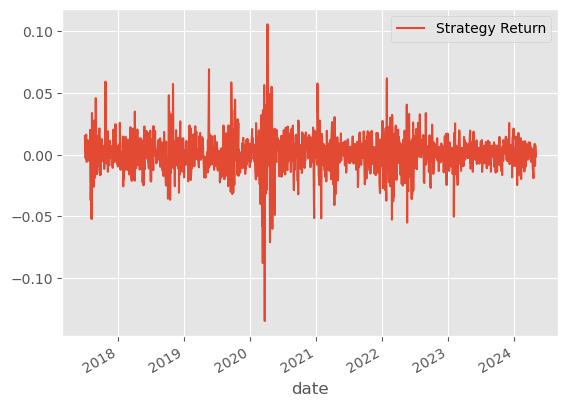

In [25]:
portfolio_df.plot()

In [26]:
pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T

ADANIENT.NS  DRREDDY.NS  HCLTECH.NS  HDFCLIFE.NS  HINDUNILVR.NS  \
0     0.083333    0.083333    0.083333     0.083333       0.083333   

   INDUSINDBK.NS   INFY.NS   LTIM.NS  SUNPHARMA.NS    TCS.NS  TECHM.NS  \
0       0.083333  0.083333  0.083333      0.083333  0.083333  0.083333   

   WIPRO.NS  
0  0.083333

In [27]:
nifty = yf.download(tickers='^NSEI',
                  start='2015-01-01',
                  end=dt.date.today())

nifty_ret = np.log(nifty[['Adj Close']]).diff().dropna().rename({'Adj Close':'nifty Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(nifty_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


Strategy Return  nifty Buy&Hold
2017-07-03         0.015159        0.009835
2017-07-04         0.002853       -0.000177
2017-07-05         0.009479        0.002525
2017-07-06         0.001984        0.003827
2017-07-07        -0.002858       -0.000905
...                     ...             ...
2024-04-23         0.008730        0.001414
2024-04-24        -0.002832        0.001537
2024-04-25        -0.009134        0.007469
2024-04-26         0.007717       -0.006686
2024-04-29        -0.001520        0.009917

[1681 rows x 2 columns]

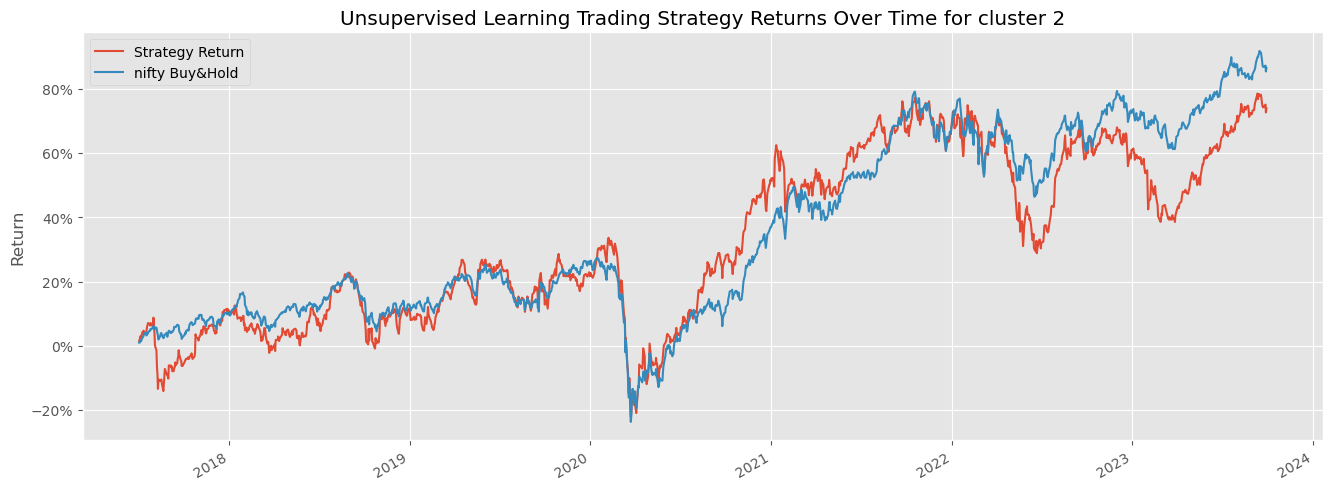

In [28]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time for cluster 2')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()

In [29]:
import numpy as np

# Assuming 'portfolio_df' has the 'Strategy Return' and 'nifty Buy&Hold' columns
strategy_returns = portfolio_df['Strategy Return']
nifty_returns = portfolio_df['nifty Buy&Hold']

# Calculate Sharpe ratio for the strategy
strategy_sharpe_ratio = np.sqrt(252) * strategy_returns.mean() / strategy_returns.std()

# Calculate Sharpe ratio for NIFTY 50
nifty_sharpe_ratio = np.sqrt(252) * nifty_returns.mean() / nifty_returns.std()

# Print the Sharpe Ratios
print(f"Strategy Sharpe Ratio: {strategy_sharpe_ratio:.4f}")
print(f"NIFTY 50 Sharpe Ratio: {nifty_sharpe_ratio:.4f}")


Strategy Sharpe Ratio: 0.5378
NIFTY 50 Sharpe Ratio: 0.7385
